<a href="https://colab.research.google.com/github/angiegh2002/capital-bike-diaries/blob/main/DM_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capital Bike Share Diaries: Data Mining Project

## 1. Introduction

### 1.1. Project Overview
* Briefly describe the project's goal (analyzing daily bike trips in Washington D.C.).

### 1.2. Objectives
* List the main objectives as stated in the document (understanding usage patterns, weather impact, high activity zones, etc.).

### 1.3. Datasets
* List the datasets to be used (Daily Bikes Trips, Daily Weather Info, Stations Info, etc.).

### 1.4. Tools and Libraries
* Mention the programming language (Python) and permitted frameworks (Pandas, NumPy, Plotly, Scikit-Learn, etc.).

## 2. Setup Environment

#### 2.0.1 Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### 2.0.2 Installing Libraries

In [ ]:
%%capture
!pip install -U kaleido
!pip install geopandas
!pip install -U shapely pyproj rtree
!pip install pygeohash
!pip install missingno
!pip install folium


In [ ]:
!pip install --no-binary=cairocffi cairocffi  # تثبيت cairocffi بدون binary
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cairocffi: filename=cairocffi-1.7.1-py3-none-any.whl size=75653 sha256=93bcbd7aa08e3fd392eab887d2ee76622b334c0b3fab3567d30435c305fc669d
  Stored in directory: /root/.cache/pip/wheels/74/92/10/22ae13cbd0967069c80e106e5baa20334c2dc1f3111ade7f9a
Successfully built cairocffi


In [ ]:
!pip install --upgrade plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 111.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


### 2.1. Import Libraries

In [ ]:
# Import necessary libraries
import os
import plotly.io as pio
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import folium
import pygeohash
import missingno as msno
from scipy import stats
from shapely.geometry import Point
import geopandas as gpd
from scipy.spatial import KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import datetime
import math

import pygeohash as pgh
from shapely.geometry import box


### 2.2. Load Datasets
* Load each dataset into pandas/geopandas DataFrames.
* Display the head and info for each dataset to get a first look.

In [ ]:
data_folder_path = "/content/drive/MyDrive/Data Mining Homework/Homework 01/data"

# List the files in the data folder
files = [f for f in os.listdir(data_folder_path) if os.path.isfile(os.path.join(data_folder_path, f))]

# Create a dictionary to store dataframes
dataframes = {}

# Load each file into a pandas DataFrame
for file_name in files:
    file_path = os.path.join(data_folder_path, file_name)
    try:
        df_name = os.path.splitext(file_name)[0] # Use filename without extension as dataframe key
        if file_name.endswith('.csv'):
            dataframes[df_name] = pd.read_csv(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.parquet'):
            dataframes[df_name] = pd.read_parquet(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.geojson'):
            # You might need to install geopandas: pip install geopandas
            dataframes[df_name] = gpd.read_file(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        else:
            print(f"Skipping unknown file type: {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

Successfully loaded DDOT_Central_Business_District.geojson into dataframe 'DDOT_Central_Business_District'
Successfully loaded Residential_and_Visitor_Parking_Zones.geojson into dataframe 'Residential_and_Visitor_Parking_Zones'
Successfully loaded Capital_Bikeshare_Locations.csv into dataframe 'Capital_Bikeshare_Locations'
Successfully loaded Washington,DC,USA 2024-01-01 to 2024-12-31.csv into dataframe 'Washington,DC,USA 2024-01-01 to 2024-12-31'
Successfully loaded Metro_Bus_Stops.csv into dataframe 'Metro_Bus_Stops'
Successfully loaded Shuttle_Bus_Stops.csv into dataframe 'Shuttle_Bus_Stops'
Successfully loaded stations.csv into dataframe 'stations'
Successfully loaded daily-rent-sampled.parquet into dataframe 'daily-rent-sampled'
Successfully loaded daily-rent.parquet into dataframe 'daily-rent'


Data Frames names:
- Daily Bikes Trips
- Daily Weather Info
- Stations Info Dataset
- Stations Table
- CBD Polygon
- Metro Bus Stops
- Shuttle Bus Stops
- Residential and Visitor Parking Zones

In [ ]:
stations_info_df = dataframes['Capital_Bikeshare_Locations']
metro_bus_stops_df = dataframes['Metro_Bus_Stops']
shuttle_bus_stops_df = dataframes['Shuttle_Bus_Stops']
daily_weather_info_df = dataframes['Washington,DC,USA 2024-01-01 to 2024-12-31']
daily_bikes_trips_df=dataframes['daily-rent']
# daily_bikes_trips_df=dataframes['daily-rent-sampled']
stations_table_df = dataframes['stations']
cbd_polygon_df = dataframes['DDOT_Central_Business_District']
residential_and_visitor_parking_zones_df = dataframes['Residential_and_Visitor_Parking_Zones']

## 3. Data Cleaning and Integration (Preprocessing)

### 3.1. Initial Data Inspection
* Check for missing values (`.isnull().sum()`).
* Check data types (`.dtypes`).
* Check for duplicates (`.duplicated().sum()`).
* Basic descriptive statistics (`.describe(include='all')`).

##### 3.1.1 For Daily Bikes Trips


###### Data Info

In [ ]:
daily_bikes_trips_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,38.921233,-77.018135,member
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,38.898243,-77.026235,casual


In [ ]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    string        
 6   end_station_name    string        
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
dtypes: datetime64[ns](2), float64(4), string(7)
memory usage: 606.4 MB


In [ ]:
daily_bikes_trips_df.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
count,6114323,6114323,6114323,6114323,4923357,4923357,4878156,4876629,6.114323e+06,6.114323e+06,6.109673e+06,6.109673e+06,6114323
unique,6114182,2,NaN,NaN,818,803,818,803,NaN,NaN,NaN,NaN,2
top,3A14268683BA3FCE,electric_bike,NaN,NaN,Columbus Circle / Union Station,31623,Columbus Circle / Union Station,31623,NaN,NaN,NaN,NaN,member
freq,2,3404885,NaN,NaN,55508,55508,55458,55437,NaN,NaN,NaN,NaN,4059247
mean,NaN,NaN,2024-07-18 16:52:01.082998016,2024-07-18 18:43:22.552895744,NaN,NaN,NaN,NaN,3.890560e+01,-7.703176e+01,3.890488e+01,-7.703157e+01,NaN
min,NaN,NaN,1970-01-01 00:00:00,2000-01-01 15:55:56,NaN,NaN,NaN,NaN,-8.960010e+01,-1.716215e+02,-8.839068e+01,-1.723373e+02,NaN
25%,NaN,NaN,2024-05-03 10:55:45.500000,2024-05-03 11:15:35.500000,NaN,NaN,NaN,NaN,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01,NaN
50%,NaN,NaN,2024-07-26 11:27:16.340999936,2024-07-26 11:47:01.260000,NaN,NaN,NaN,NaN,3.890550e+01,-7.703000e+01,3.890383e+01,-7.703000e+01,NaN
75%,NaN,NaN,2024-10-06 17:20:19.227500032,2024-10-06 17:41:45.916499968,NaN,NaN,NaN,NaN,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01,NaN
max,NaN,NaN,2024-12-31 23:54:46.421000,2030-01-01 00:00:00,NaN,NaN,NaN,NaN,8.582003e+01,5.993410e+01,8.957352e+01,5.730187e+01,NaN


###### Unique Values

In [ ]:
daily_bikes_trips_df.nunique()

,0
ride_id,6114182
rideable_type,2
started_at,5866403
ended_at,5869571
start_station_name,818
start_station_id,803
end_station_name,818
end_station_id,803
start_lat,468450
start_lng,501510


###### Duplicated Rows

In [ ]:
print(daily_bikes_trips_df.duplicated().sum())

0


In [ ]:
print(daily_bikes_trips_df.duplicated(subset=['ride_id']).sum())

141


In [ ]:
duplicated_rows = daily_bikes_trips_df[daily_bikes_trips_df.duplicated(subset=['ride_id'], keep=False)]
duplicated_rows.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1493305,A0D6E0D07416BB2A,classic_bike,2024-05-31 23:12:54,2024-06-01 00:07:43,Gravelly Point,31064,Potomac Ave & Swann Ave,31916,38.865029,-77.039511,38.829545,-77.047844,member
1504876,3274F26728D10261,classic_bike,2024-05-31 20:58:48,2024-06-01 04:06:37,Smithsonian-National Mall / Jefferson Dr & 12t...,31248,Wisconsin Ave & Rodman St NW,31333,38.888774,-77.028694,38.939674,-77.075277,casual
1506981,A9A7B0B468FBBE1B,classic_bike,2024-05-31 07:56:41,2024-06-01 08:15:58,8th & Eye St SE / Barracks Row,31608,1st & I St SE,31628,38.879200,-76.995300,38.878854,-77.005727,member
1508631,3377EF31A5964D3C,classic_bike,2024-05-31 07:39:54,2024-06-01 08:15:58,C & O Canal & Wisconsin Ave NW,31225,1st & I St SE,31628,38.903750,-77.062690,38.878854,-77.005727,member
1509898,59798416D0A9F527,classic_bike,2024-05-31 09:15:14,2024-06-01 08:15:58,1st & M St SE,31650,1st & I St SE,31628,38.876893,-77.006072,38.878854,-77.005727,member


In [ ]:
daily_bikes_trips_df = daily_bikes_trips_df.drop_duplicates(subset=['ride_id'], keep='first')

###### Null Values

In [ ]:
print(daily_bikes_trips_df.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1190946
start_station_id      1190946
end_station_name      1236126
end_station_id        1237653
start_lat                   0
start_lng                   0
end_lat                  4637
end_lng                  4637
member_casual               0
dtype: int64


In [ ]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['end_station_id',"end_station_name", 'end_lat',"end_lng"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['end_station_id','end_station_name', 'end_lat','end_lng']:\n{count}")

Number of rows that have missing values in ['end_station_id','end_station_name', 'end_lat','end_lng']:
4637


In [ ]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['end_station_id',"end_station_name"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['end_station_id','end_station_name']:\n{count}")

Number of rows that have missing values in ['end_station_id','end_station_name']:
1236126


In [ ]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['start_station_id',"start_station_name"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['start_station_id','start_station_name']:\n{count}")

Number of rows that have missing values in ['start_station_id','start_station_name']:
1190946


<Axes: >

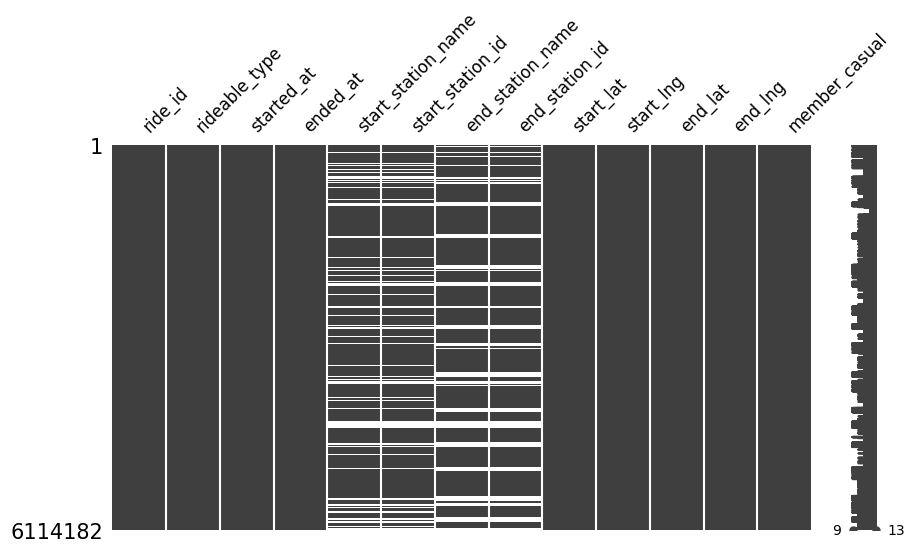

In [ ]:
msno.matrix(daily_bikes_trips_df, figsize=(10,5), fontsize=12)

<Axes: >

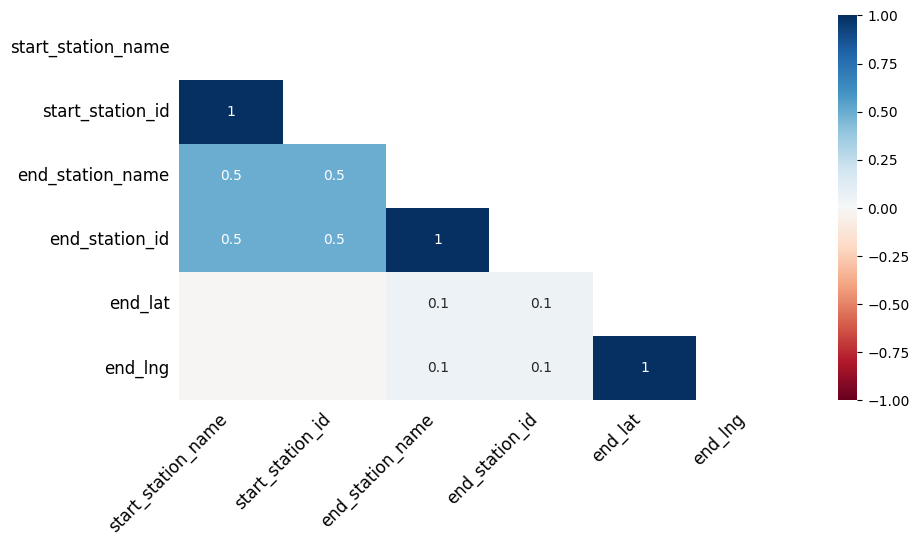

In [ ]:
msno.heatmap(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

<Axes: >

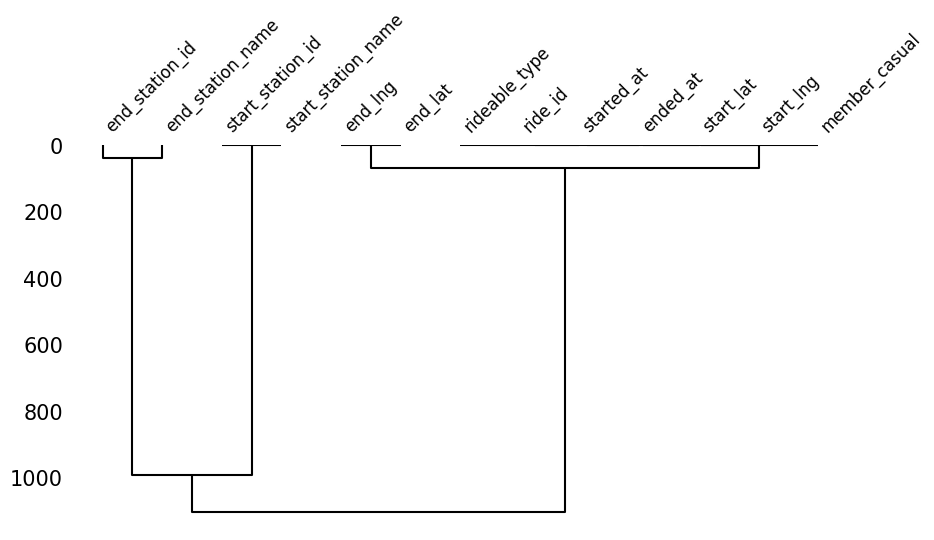

In [ ]:
msno.dendrogram(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

######Out layer

In [ ]:
# حساب عدد الرحلات لكل نوع دراجة
bike_type_counts = daily_bikes_trips_df['rideable_type'].value_counts().reset_index()
bike_type_counts.columns = ['rideable_type', 'count']

# حساب النسبة المئوية
total_rides = bike_type_counts['count'].sum()
bike_type_counts['percentage'] = (bike_type_counts['count'] / total_rides) * 100

# إنشاء المخطط الدائري
fig = px.pie(bike_type_counts,
             values='count',
             names='rideable_type',
             title='توزيع أنواع الدراجات حسب الرحلات',
             hover_data=['percentage'],
             labels={'rideable_type':'نوع الدراجة', 'count':'عدد الرحلات', 'percentage':'النسبة المئوية'})

# تحديث تنسيق النص ليشمل النسبة المئوية
fig.update_traces(textposition='inside', textinfo='percent+label')

# عرض المخطط
# fig.write_image("bike_type_pie_chart.png")
pio.show(fig,renderers="png")

In [ ]:
# حساب مدة الرحلة بالثواني
daily_bikes_trips_df['duration'] = (daily_bikes_trips_df['ended_at'] - daily_bikes_trips_df['started_at']).dt.total_seconds()

/tmp/ipython-input-28-1991676314.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# 1.  الرحلات القصيرة جداً (< 60 ثانية)
short_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['duration'] <= 60]
short_bikes_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
38,D462EB06D9E394F1,electric_bike,2024-01-29 11:51:45.000,2024-01-29 11:52:30.000,Wilson Blvd & N Oak St,31939,<NA>,<NA>,38.895056,-77.073714,38.89,-77.08,member,45.000
270,9A0BF921EA05585C,electric_bike,2024-01-23 10:58:40.000,2024-01-23 10:59:37.000,14th & Harvard St NW,31105,<NA>,<NA>,38.926763,-77.032258,38.93,-77.03,member,57.000
285,0F758A88D40D4485,electric_bike,2024-01-23 18:09:17.000,2024-01-23 18:09:27.000,Neal St & Trinidad Ave NE,31512,<NA>,<NA>,38.903772,-76.987301,38.90,-76.99,member,10.000
302,40E6EFCF6F6C11F2,electric_bike,2024-01-13 15:39:12.000,2024-01-13 15:39:12.000,Metro Center / 12th & G St NW,31230,<NA>,<NA>,38.898139,-77.027641,38.90,-77.03,member,0.000
307,60A27E59B54EBAF7,electric_bike,2024-01-12 15:34:49.000,2024-01-12 15:34:56.000,Metro Center / 12th & G St NW,31230,<NA>,<NA>,38.898112,-77.028031,38.90,-77.03,casual,7.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114255,4BA07BAF30E58BF0,electric_bike,2024-12-29 11:33:02.687,2024-12-29 11:33:12.772,<NA>,<NA>,<NA>,<NA>,38.850000,-76.980000,38.85,-76.98,member,10.085
6114262,3B87866EFC037F0A,electric_bike,2024-12-29 12:51:55.717,2024-12-29 12:52:55.023,<NA>,<NA>,<NA>,<NA>,38.850000,-76.980000,38.85,-76.98,member,59.306
6114280,885259216DB56E04,electric_bike,2024-12-17 17:43:05.540,2024-12-17 17:43:12.643,Georgia Ave & Dahlia St NW,31425,<NA>,<NA>,38.976061,-77.026747,38.98,-77.03,casual,7.103
6114282,1B7A14D35DA2C764,electric_bike,2024-12-26 15:13:44.847,2024-12-26 15:14:00.384,S Randolph St & Campbell Ave,31076,<NA>,<NA>,38.840654,-77.088659,38.84,-77.09,casual,15.537


In [ ]:
# 2.  الرحلات الطويلة جداً (> 24 ساعة)
long_bikes_trips_df = daily_bikes_trips_df[
    (daily_bikes_trips_df['duration'] >= 86400) &
    (daily_bikes_trips_df['end_lat'].notna()) &
    (daily_bikes_trips_df['end_lng'].notna())
]
long_bikes_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
14765,45ECB714FB05AE24,classic_bike,2024-01-25 11:18:14.000,2024-01-26 12:10:40.000,Kenilworth Terr & Hayes St. NE,31717,Rhode Island Ave Metro,31516,38.900468,-76.947287,38.920682,-76.995876,casual,8.954600e+04
24024,39F7EA3B307BA4EA,classic_bike,2024-01-22 08:23:19.000,2024-01-23 09:23:00.000,Tenleytown / Wisconsin Ave & Albemarle St NW,31303,<NA>,<NA>,38.947607,-77.079382,38.940000,-77.090000,casual,8.998100e+04
45591,AD11CE697E5DC9BF,classic_bike,2024-01-06 09:30:13.000,2024-01-07 10:29:58.000,Eastern Market / 7th & North Carolina Ave SE,31610,<NA>,<NA>,38.886952,-76.996806,38.880000,-77.000000,casual,8.998500e+04
59159,5F2FAB798BF9D285,classic_bike,2024-01-01 00:28:09.000,2024-01-02 01:28:00.000,18th & C St NW,31284,<NA>,<NA>,38.893511,-77.041544,38.910000,-77.040000,casual,8.999100e+04
59188,1A12B3C3584C9759,classic_bike,2024-01-24 15:23:38.000,2024-01-25 16:23:30.000,22nd St & Constitution Ave NW,31292,<NA>,<NA>,38.892441,-77.048947,38.890000,-77.050000,casual,8.999200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920081,17C58119F7F14250,classic_bike,2024-12-28 21:14:29.809,2024-12-29 22:14:24.280,King St & Patrick St,31044,<NA>,<NA>,38.805317,-77.049883,38.820000,-77.050000,casual,8.999447e+04
5951849,DA0BE5328F09B50B,electric_bike,1970-01-01 00:00:00.000,2024-12-01 13:24:28.289,<NA>,<NA>,<NA>,<NA>,38.920000,-76.990000,38.910000,-77.040000,member,1.733059e+09
5957025,B00764530DF95E12,classic_bike,2024-12-27 17:26:49.553,2024-12-28 18:26:44.378,W&OD Trail & Explorer St/Reston Bus Station,32214,<NA>,<NA>,38.957037,-77.359718,38.960000,-77.350000,casual,8.999482e+04
5987188,3B4589BFC8B7E3F5,classic_bike,2024-12-18 08:58:48.595,2024-12-19 09:32:14.627,11th & Kenyon St NW,31102,15th & M St NW,31298,38.929464,-77.027822,38.905424,-77.034674,member,8.840603e+04


In [ ]:
# 3.  الرحلات التي بدأت بعد انتهائها
start_after_end_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['started_at'] > daily_bikes_trips_df['ended_at']]
start_after_end_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
5407,82AB913D4EF90555,electric_bike,2024-01-20 19:20:18.000,2024-01-20 19:20:17.000,Eckington Pl & Q St NE,31505,<NA>,<NA>,38.911022,-77.004981,38.910000,-77.000000,member,-1.000
6252,2A88A56C2B0B0687,electric_bike,2024-01-03 16:35:44.000,2024-01-03 16:35:41.000,Metro Center / 12th & G St NW,31230,<NA>,<NA>,38.898335,-77.027644,38.900000,-77.030000,member,-3.000
44610,50C76C14CB49538B,electric_bike,2024-01-01 19:00:15.000,2024-01-01 19:00:14.000,6th & K St NE,31645,<NA>,<NA>,38.903058,-76.998434,38.900000,-77.000000,casual,-1.000
54892,C07C8BCEC9D547FB,electric_bike,2024-01-27 17:47:05.000,2024-01-27 17:47:04.000,Takoma Metro,31408,Takoma Metro,31408,38.975203,-77.016856,38.975219,-77.016855,casual,-1.000
76685,DE163C18B49DAF6B,electric_bike,2024-01-18 07:21:03.000,2024-01-18 07:21:02.000,N Pershing Dr & N George Mason Dr,31069,<NA>,<NA>,38.871791,-77.107953,38.870000,-77.110000,casual,-1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683846,1B558B48B9C8766A,electric_bike,2024-11-03 01:55:09.461,2024-11-03 01:09:12.902,20th & O St NW / Dupont South,31234,<NA>,<NA>,38.909048,-77.044669,38.930000,-77.020000,member,-2756.559
5684312,2AC2CE58664A8D62,electric_bike,2024-11-03 01:55:15.855,2024-11-03 01:13:28.133,Washington Blvd & Walter Reed Dr,31073,<NA>,<NA>,38.873219,-77.082104,38.850000,-77.050000,casual,-2507.722
5688849,BF57186DCB8CD5AB,electric_bike,2024-11-03 01:44:53.788,2024-11-03 01:10:10.656,13th & H St NE,31611,<NA>,<NA>,38.900427,-76.988250,38.920000,-77.040000,member,-2083.132
5691032,C4CCA7A748AED3EA,electric_bike,2024-11-03 01:15:14.831,2024-11-03 01:12:44.083,<NA>,<NA>,<NA>,<NA>,38.920000,-77.030000,38.920000,-77.030000,member,-150.748


In [ ]:

invalid_coords = daily_bikes_trips_df[
    daily_bikes_trips_df['start_lat'].isna() |
    daily_bikes_trips_df['start_lng'].isna() |
    ((daily_bikes_trips_df['start_lat'] == 0) & (daily_bikes_trips_df['start_lng'] == 0))
]
invalid_coords

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
74999,21D12F2A70A20E00,electric_bike,2024-01-30 15:41:52.000,2024-01-30 15:53:39.000,Glebe Rd & 11th St N,31038,Washington Blvd & 7th St N,31032,0.0,0.0,0.0,0.0,casual,707.000
142242,D71342009F88CC6C,electric_bike,2024-01-30 11:29:35.000,2024-01-30 11:35:08.000,Georgia & New Hampshire Ave NW,31400,<NA>,<NA>,0.0,0.0,0.0,0.0,member,333.000
215570,CBC7BC0378A8191D,electric_bike,2024-01-30 07:00:12.000,2024-01-30 07:05:45.000,14th & Belmont St NW,31119,18th & New Hampshire Ave NW,31324,0.0,0.0,0.0,0.0,casual,333.000
658823,BC6D07306F9AB01F,classic_bike,2024-03-13 21:10:52.000,2024-03-13 21:44:23.000,Pentagon City Metro / 12th St & S Hayes St,31005,Eads St & 12th St S,31071,0.0,0.0,0.0,0.0,casual,2011.000
697252,14FEE93EBE065F86,classic_bike,2024-03-20 11:03:42.000,2024-03-20 11:23:07.000,M St & Delaware Ave NE,31627,20th St & Florida Ave NW,31110,0.0,0.0,0.0,0.0,member,1165.000
728005,8FB6D0C1D11CE9C0,electric_bike,2024-03-24 20:37:04.000,2024-03-24 23:16:45.000,20th & O St NW / Dupont South,31234,12th & U St NW,31268,0.0,0.0,0.0,0.0,casual,9581.000
781344,E067FDF8DC37923D,electric_bike,2024-03-09 06:53:19.000,2024-03-09 07:03:22.000,17th & K St NW,31213,7th & F St NW / National Portrait Gallery,31232,0.0,0.0,0.0,0.0,member,603.000
814686,137A502D2A6DE710,electric_bike,2024-03-08 17:38:32.000,2024-03-08 17:47:09.000,New Hampshire Ave & T St NW,31229,Convention Center / 7th & M St NW,31223,0.0,0.0,0.0,0.0,member,517.000
913346,696F1CC563B7A6CF,electric_bike,2024-03-29 12:45:48.000,2024-03-29 12:46:08.000,Columbia Pike & S Highland St,31096,<NA>,<NA>,0.0,0.0,0.0,0.0,member,20.000
1082667,6E07244EA2A418F4,classic_bike,2024-04-30 07:49:21.000,2024-04-30 08:02:00.000,7th & S St NW,31130,11th & F St NW,31262,0.0,0.0,0.0,0.0,member,759.000


In [ ]:

invalid_e_coords = daily_bikes_trips_df[
    daily_bikes_trips_df['end_lat'].isna() |
    daily_bikes_trips_df['end_lng'].isna() |
    ((daily_bikes_trips_df['end_lat'] == 0) & (daily_bikes_trips_df['end_lng'] == 0))
]
invalid_coords

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
74999,21D12F2A70A20E00,electric_bike,2024-01-30 15:41:52.000,2024-01-30 15:53:39.000,Glebe Rd & 11th St N,31038,Washington Blvd & 7th St N,31032,0.0,0.0,0.0,0.0,casual,707.000
142242,D71342009F88CC6C,electric_bike,2024-01-30 11:29:35.000,2024-01-30 11:35:08.000,Georgia & New Hampshire Ave NW,31400,<NA>,<NA>,0.0,0.0,0.0,0.0,member,333.000
215570,CBC7BC0378A8191D,electric_bike,2024-01-30 07:00:12.000,2024-01-30 07:05:45.000,14th & Belmont St NW,31119,18th & New Hampshire Ave NW,31324,0.0,0.0,0.0,0.0,casual,333.000
658823,BC6D07306F9AB01F,classic_bike,2024-03-13 21:10:52.000,2024-03-13 21:44:23.000,Pentagon City Metro / 12th St & S Hayes St,31005,Eads St & 12th St S,31071,0.0,0.0,0.0,0.0,casual,2011.000
697252,14FEE93EBE065F86,classic_bike,2024-03-20 11:03:42.000,2024-03-20 11:23:07.000,M St & Delaware Ave NE,31627,20th St & Florida Ave NW,31110,0.0,0.0,0.0,0.0,member,1165.000
728005,8FB6D0C1D11CE9C0,electric_bike,2024-03-24 20:37:04.000,2024-03-24 23:16:45.000,20th & O St NW / Dupont South,31234,12th & U St NW,31268,0.0,0.0,0.0,0.0,casual,9581.000
781344,E067FDF8DC37923D,electric_bike,2024-03-09 06:53:19.000,2024-03-09 07:03:22.000,17th & K St NW,31213,7th & F St NW / National Portrait Gallery,31232,0.0,0.0,0.0,0.0,member,603.000
814686,137A502D2A6DE710,electric_bike,2024-03-08 17:38:32.000,2024-03-08 17:47:09.000,New Hampshire Ave & T St NW,31229,Convention Center / 7th & M St NW,31223,0.0,0.0,0.0,0.0,member,517.000
913346,696F1CC563B7A6CF,electric_bike,2024-03-29 12:45:48.000,2024-03-29 12:46:08.000,Columbia Pike & S Highland St,31096,<NA>,<NA>,0.0,0.0,0.0,0.0,member,20.000
1082667,6E07244EA2A418F4,classic_bike,2024-04-30 07:49:21.000,2024-04-30 08:02:00.000,7th & S St NW,31130,11th & F St NW,31262,0.0,0.0,0.0,0.0,member,759.000


###### Summary

- There are a 26 row duplicated
- Whenever end_lat and end_lng are missing, end_station_name and end_station_id are also missing for those same rows

##### 3.1.2 For Stations Table


###### Data Info

In [ ]:
stations_table_df.head()

,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [ ]:
stations_table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [ ]:
stations_table_df.describe(include='all')

,id,name
count,821.000000,821
unique,NaN,820
top,NaN,Randle Circle & Minnesota Ave SE
freq,NaN,2
mean,31650.894032,NaN
std,447.232558,NaN
min,30200.000000,NaN
25%,31263.000000,NaN
50%,31630.000000,NaN
75%,32022.000000,NaN


###### Unique Values

In [ ]:
stations_table_df.nunique()

,0
id,804
name,820


In [ ]:
rows_with_non_unique_name = stations_table_df[stations_table_df.duplicated(subset=['name'], keep=False)]
print("Rows with non-unique Names:")
rows_with_non_unique_name

Rows with non-unique Names:


,id,name
465,31702,Randle Circle & Minnesota Ave SE
492,31799,Randle Circle & Minnesota Ave SE


In [ ]:
# drop duplicated name row
stations_table_df = stations_table_df.drop_duplicates(subset=['name'], keep='first')

In [ ]:
rows_with_non_unique_id = stations_table_df[stations_table_df.duplicated(subset=['id'], keep=False)]
print("Rows with non-unique IDs:")
rows_with_non_unique_id

Rows with non-unique IDs:


,id,name
45,31045,S Payne St & King St
46,31045,Commerce St & Fayette St
133,31133,20th & Columbia Rd NW
134,31133,20th St & Columbia Rd NW
135,31133,19th St & Wyoming Ave NW
166,31225,C & O Canal & Wisconsin Ave NW
167,31225,Wisconsin Ave & K St NW
281,31339,18th St & Ingleside Terr NW
282,31339,18th St & Ingleside Ter NW
284,31380,Roland Clarke Pl & Sunrise Valley Dr


###### Duplicated Rows

In [ ]:
print(stations_table_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(stations_table_df.isnull().sum())

id      0
name    0
dtype: int64


###### Summary

- There is one name duplicated "Randle Circle & Minnesota Ave SE", and 17 IDs duplicated.
- There are no missing values

##### 3.1.3 For Stations Info

###### Data Info

In [ ]:
stations_info_df.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [ ]:
stations_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

In [ ]:
stations_info_df.describe(include='all')

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
count,7.940000e+02,7.940000e+02,794,794,794,0.0,794,794.00000,794.000000,794.000000,...,794,794.000000,794,744.000000,794,0.0,794.000000,794.000000,794,7.940000e+02
unique,NaN,NaN,794,1,794,NaN,125,NaN,NaN,NaN,...,1,NaN,1,NaN,1,NaN,NaN,NaN,2,NaN
top,NaN,NaN,Old Meadow Rd & Cathy Ln,classic,1890899920583743818,NaN,2025/05/05 20:26:08+00,NaN,NaN,NaN,...,NO,NaN,"KEY,CREDITCARD",NaN,DCA-CABI,NaN,NaN,NaN,2025/05/05 20:27:29+00,NaN
freq,NaN,NaN,1,794,1,NaN,14,NaN,NaN,NaN,...,794,NaN,794,NaN,794,NaN,NaN,NaN,604,NaN
mean,-8.579029e+06,4.708386e+06,NaN,NaN,NaN,NaN,NaN,10.13728,0.021411,6.419395,...,NaN,17.234257,NaN,53.034946,NaN,NaN,38.907156,-77.066727,NaN,2.612862e+08
std,1.073636e+04,8.392150e+03,NaN,NaN,NaN,NaN,NaN,6.07810,0.271923,5.968744,...,NaN,5.712581,NaN,27.714636,NaN,NaN,0.058643,0.096446,NaN,3.217789e+03
min,-8.614982e+06,4.688330e+06,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,...,NaN,8.000000,NaN,40.000000,NaN,NaN,38.766844,-77.389696,NaN,2.612840e+08
25%,-8.582008e+06,4.704036e+06,NaN,NaN,NaN,NaN,NaN,5.00000,0.000000,2.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.876769,-77.093483,NaN,2.612842e+08
50%,-8.576564e+06,4.707386e+06,NaN,NaN,NaN,NaN,NaN,10.00000,0.000000,5.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.900192,-77.044581,NaN,2.612844e+08
75%,-8.572478e+06,4.711950e+06,NaN,NaN,NaN,NaN,NaN,14.00000,0.000000,10.000000,...,NaN,19.000000,NaN,43.000000,NaN,NaN,38.932094,-77.007883,NaN,2.612846e+08


In [ ]:
stations_info_df = stations_info_df[[
    'STATION_ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CAPACITY'
]]

###### Unique Values

In [ ]:
stations_info_df.nunique()

,0
STATION_ID,794
NAME,794
LATITUDE,789
LONGITUDE,792
CAPACITY,29


###### Duplicated Rows

In [ ]:
print(stations_info_df.duplicated().sum())

0


In [ ]:
dublicate_name=stations_info_df[stations_info_df.duplicated(subset=["NAME"])]
dublicate_name

,STATION_ID,NAME,LATITUDE,LONGITUDE,CAPACITY


###### Null Values

In [ ]:
print(stations_info_df.isnull().sum())

STATION_ID    0
NAME          0
LATITUDE      0
LONGITUDE     0
CAPACITY      0
dtype: int64


###### Merge with Stations Table Dataframe

In [ ]:
stations_df = pd.merge(stations_info_df, stations_table_df, left_on='NAME', right_on='name', how='inner')
stations_df = stations_df.drop(columns=['name'])
stations_df["id"]=stations_df["id"].astype("Int64")
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION_ID  776 non-null    object 
 1   NAME        776 non-null    object 
 2   LATITUDE    776 non-null    float64
 3   LONGITUDE   776 non-null    float64
 4   CAPACITY    776 non-null    int64  
 5   id          776 non-null    Int64  
dtypes: Int64(1), float64(2), int64(1), object(2)
memory usage: 37.3+ KB


In [ ]:
invalid = stations_df[
    stations_df['LATITUDE'].isna() |
    stations_df['LONGITUDE'].isna() |
    ((stations_df['LATITUDE'] == 0) & (stations_df['LONGITUDE'] == 0))
]
invalid

,STATION_ID,NAME,LATITUDE,LONGITUDE,CAPACITY,id


###### Summary

- There are no duplicated rows.
- There is no data in "STATION_STATUS" and "GIS_ID" columns.

##### 3.1.4 For Daily Weather Info

###### Data Info

In [ ]:
daily_weather_info_df.head()

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,"Washington,DC,USA",2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,"Washington,DC,USA",2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,"Washington,DC,USA",2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,"Washington,DC,USA",2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,"Washington,DC,USA",2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [ ]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


In [ ]:
daily_weather_info_df.describe(include='all')

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
count,366,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366,366,366.000000,366,366,366
unique,1,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366,366,NaN,8,33,6
top,"Washington,DC,USA",2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-31T07:26:48,2024-12-31T16:56:19,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
freq,366,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,197,159,196
mean,NaN,NaN,20.795355,12.082514,16.251913,62.434973,23.338798,23.338798,12.787158,3.256831,63.997268,NaN,NaN,0.486667,NaN,NaN,NaN
std,NaN,NaN,9.442725,8.762690,8.885863,13.624988,7.714631,7.714631,4.696460,4.002540,25.299497,NaN,NaN,0.292243,NaN,NaN,NaN
min,NaN,NaN,-1.700000,-9.000000,-5.000000,32.600000,8.900000,8.900000,3.400000,0.000000,2.100000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,12.800000,4.900000,8.825000,52.625000,17.700000,17.700000,9.500000,0.000000,45.225000,NaN,NaN,0.250000,NaN,NaN,NaN
50%,NaN,NaN,22.100000,11.950000,17.550000,61.850000,21.950000,21.950000,12.250000,0.500000,68.300000,NaN,NaN,0.500000,NaN,NaN,NaN
75%,NaN,NaN,28.375000,19.900000,24.075000,71.975000,27.275000,27.275000,15.400000,6.700000,84.775000,NaN,NaN,0.750000,NaN,NaN,NaN


In [ ]:
daily_weather_info_df = daily_weather_info_df[[
    "datetime", "conditions", "temp", "windspeedmean", "humidity"
]]

###### Unique Values

In [ ]:
daily_weather_info_df.nunique()

,0
datetime,366
conditions,8
temp,222
windspeedmean,153
humidity,276


In [ ]:
conditions_value=daily_weather_info_df["conditions"].unique()
conditions_value

array(['Rain, Overcast', 'Partially cloudy', 'Rain, Partially cloudy',
       'Snow, Rain, Overcast', 'Snow, Rain, Partially cloudy', 'Clear',
       'Snow, Partially cloudy', 'Overcast'], dtype=object)

###### Duplicated Rows

In [ ]:
print(daily_weather_info_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(daily_weather_info_df.isnull().sum())

datetime         0
conditions       0
temp             0
windspeedmean    0
humidity         0
dtype: int64


###### Summary

- There are no duplicated rows
- There are no missing values

##### 3.1.5 For Metro Bus Stops

###### Data Info

In [ ]:
metro_bus_stops_df.head()

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
0,-8.581259e+06,4.715817e+06,1311739,1003448,15663,PRS,2011/08/22 04:00:00+00,UNK,44TH ST NW,JENIFER ST NW,...,NaN,{CFF25BD1-E9E8-44CD-81D6-975FE646753F},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54845,NaN,NON,NaN
1,-8.540493e+06,4.714288e+06,1310541,3003035,14833,PRS,2001/12/30 05:00:00+00,REV,HARBOUR WAY,MITCHELLVILLE RD,...,NaN,{8E670BA7-FB63-4CAC-B9FC-C0901E266303},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54846,NaN,NON,NaN
2,-8.591135e+06,4.698290e+06,1302469,5000849,2134,PRS,1901/01/01 05:00:00+00,REV,SLEEPY HOLLOW MANOR,COLUMBIA PIKE,...,NaN,{22649B1B-617C-4511-9786-D465C7142788},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54847,NaN,NON,NaN
3,-8.577431e+06,4.682321e+06,1305286,5001858,11889,PRS,1974/11/25 05:00:00+00,REV,CUSHMAN PL,WAYNEWOOD BLVD,...,NaN,{AE0E1A3F-7C1D-4410-9E47-01B20568BBE0},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54848,NaN,NON,NaN
4,-8.578561e+06,4.680594e+06,1305279,5001885,11919,PRS,1901/01/01 05:00:00+00,REV,PRICES LN,VERNON VIEW DR,...,NaN,{2C8845FF-D723-4334-A3DD-4DFEA1B1C4C2},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54849,NaN,NON,NaN


In [ ]:
metro_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

In [ ]:
metro_bus_stops_df.describe(include='all')

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
count,1.004400e+04,1.004400e+04,1.004400e+04,1.004400e+04,10044.000000,10044,10044,10044,10044,10044,...,0.0,10044,10044,10044,10044,10044,10044.000000,547,10044,267
unique,NaN,NaN,NaN,NaN,NaN,1,1776,4,4575,1187,...,NaN,10044,1,1,1,1,NaN,1,1,52
top,NaN,NaN,NaN,NaN,NaN,PRS,1901/01/01 05:00:00+00,REV,BUS BAY C,NEW HAMPSHIRE AVE,...,NaN,{F60A4E53-3D0C-4C97-BEFD-6F591FDFC657},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,NaN,YES,NON,MSTN_070
freq,NaN,NaN,NaN,NaN,NaN,10044,2777,7583,38,127,...,NaN,1,10044,10044,10044,10044,NaN,547,10044,14
mean,-8.573589e+06,4.709026e+06,1.309595e+06,2.758170e+06,10584.951016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60009.754480,NaN,NaN,NaN
std,1.292582e+04,1.178967e+04,1.779232e+04,1.580693e+06,12251.967007,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2900.900168,NaN,NaN,NaN
min,-8.621634e+06,4.677973e+06,1.300005e+06,1.000001e+06,66.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,54845.000000,NaN,NaN,NaN
25%,-8.581023e+06,4.700649e+06,1.303241e+06,1.002959e+06,4445.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57499.750000,NaN,NaN,NaN
50%,-8.572242e+06,4.707842e+06,1.306389e+06,3.000786e+06,8772.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60010.500000,NaN,NaN,NaN
75%,-8.565564e+06,4.716428e+06,1.309382e+06,3.004256e+06,13877.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,62521.250000,NaN,NaN,NaN


###### Unique Values

In [ ]:
metro_bus_stops_df.nunique()

,0
X,10044
Y,10044
EGIS_ID,10044
REG_ID,10044
BSTP_GEO_ID,9904
...,...
EDITED,1
OBJECTID,10044
SNOWPRIORITY,1
BSTP_OPS_FTU_TCD,1


###### Duplicated Rows

In [ ]:
print(metro_bus_stops_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(metro_bus_stops_df.isnull().sum())

X                      0
Y                      0
EGIS_ID                0
REG_ID                 0
BSTP_GEO_ID            0
                    ... 
EDITED                 0
OBJECTID               0
SNOWPRIORITY        9497
BSTP_OPS_FTU_TCD       0
MSTN_ID             9777
Length: 79, dtype: int64


###### Summary

- There is no data in "SNOWPRIORITY" column

##### 3.1.6 For Shuttle Bus

###### Data Info

In [ ]:
shuttle_bus_stops_df.head()

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
0,-8.581105e+06,4.715777e+06,Reston Limousine,4350 JENIFER STREET NW,Mazza Gallarie,"4350 Jennifer St. NW, Washington, DC 20015 (pi...",No,No,NaN,No,...,143439.120000,38.958828,-77.085372,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,1
1,-8.571861e+06,4.714828e+06,Reston Limousine,550 GALLOWAY STREET NE,NaN,"550 Galloway St. NE, Washington, DC 20011 - Fo...",No,No,NaN,NaN,...,142700.050000,38.952201,-77.002336,NaN,{86FD8D0D-8512-4B67-BC46-F4702DDECBF7},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,2
2,-8.580446e+06,4.714237e+06,American University,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,Tenley Town Metro,Albermarle St & 40th Street NW,No,Yes,1002492,No,...,142244.710000,38.948072,-77.079460,NaN,{39D07F3C-F0BC-4A81-A48E-B84F4476C0FB},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,3
3,-8.580342e+06,4.714213e+06,American University,FORT DRIVE NW AND ALBEMARLE STREET NW,Metro on Fort road,Fort Drive & Albemarle St,No,Yes,1002498,No,...,142225.640001,38.947901,-77.078521,NaN,{F5F56BB9-4FA5-4990-A245-49BD5CE9FF56},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,4
4,-8.580407e+06,4.713930e+06,American University,NEBRASKA AVENUE NW AND TENLEY CIRCLE NW,Tenley campus to Main Campus,Nebraska Ave NW & Tenley Circle,No,Yes,1003488,No,...,142006.200001,38.945924,-77.079102,NaN,{81C0AAA8-0A4A-46DB-B21F-290E8C261FB4},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,5


In [ ]:
shuttle_bus_stops_df.describe(include='all')

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
count,1.020000e+02,1.020000e+02,102,102,76,84,95,93,23,77,...,102.000000,102.000000,102.000000,0.0,102,0.0,0.0,102,102,102.000000
unique,NaN,NaN,25,98,71,80,3,3,22,21,...,NaN,NaN,NaN,NaN,102,NaN,NaN,1,3,NaN
top,NaN,NaN,Reston Limousine,NEBRASKA AVENUE NW FROM WARD CIRCLE NW TO 42ND...,NOMA (Gallaudet) Metro Station,Nebraska Ave NW & Mass Ave NW,No,No,No Metro Stop,No,...,NaN,NaN,NaN,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,NaN
freq,NaN,NaN,30,2,2,5,80,71,2,52,...,NaN,NaN,NaN,NaN,1,NaN,NaN,102,41,NaN
mean,-8.576019e+06,4.708610e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137877.543576,38.908756,-77.039703,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
std,2.862833e+03,2.700879e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2096.260170,0.018891,0.025716,NaN,NaN,NaN,NaN,NaN,NaN,29.588849
min,-8.582103e+06,4.704030e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,134321.460000,38.876724,-77.094343,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,-8.577548e+06,4.706898e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136547.905000,38.896778,-77.053423,NaN,NaN,NaN,NaN,NaN,NaN,26.250000
50%,-8.576228e+06,4.707775e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137229.315000,38.902911,-77.041565,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
75%,-8.574059e+06,4.709780e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138786.215000,38.916927,-77.022083,NaN,NaN,NaN,NaN,NaN,NaN,76.750000


In [ ]:
shuttle_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X                      102 non-null    float64
 1   Y                      102 non-null    float64
 2   COMPANY                102 non-null    object 
 3   ADDRESS                102 non-null    object 
 4   ATTRACTION             76 non-null     object 
 5   CROSSROADS             84 non-null     object 
 6   METERS                 95 non-null     object 
 7   METRO_BUS_ZONE         93 non-null     object 
 8   METRO_STOP_ID          23 non-null     object 
 9   OTHER                  77 non-null     object 
 10  NPS                    0 non-null      float64
 11  NUM_SHARED_OPER        102 non-null    int64  
 12  RUSH_HOUR_RESTR        95 non-null     object 
 13  LZ_HOTEL_OR_COMM       95 non-null     object 
 14  SPACE_LOC_ON_BLOCK     93 non-null     object 
 15  NO_STO

- There is no data in "NPS", "SE_ANNO_CAD_DATA", "CREATOR", and "CREATED" columns

###### Unique Values

In [ ]:
shuttle_bus_stops_df.nunique()

,0
X,96
Y,96
COMPANY,25
ADDRESS,98
ATTRACTION,71
CROSSROADS,80
METERS,3
METRO_BUS_ZONE,3
METRO_STOP_ID,22
OTHER,21


###### Duplicated Rows

In [ ]:
print(shuttle_bus_stops_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(shuttle_bus_stops_df.isnull().sum())

X                          0
Y                          0
COMPANY                    0
ADDRESS                    0
ATTRACTION                26
CROSSROADS                18
METERS                     7
METRO_BUS_ZONE             9
METRO_STOP_ID             79
OTHER                     25
NPS                      102
NUM_SHARED_OPER            0
RUSH_HOUR_RESTR            7
LZ_HOTEL_OR_COMM           7
SPACE_LOC_ON_BLOCK         9
NO_STOP_NO_STAND_AREA      8
MAR_ID                     0
GIS_ID                     0
XCOORD                     0
YCOORD                     0
LATITUDE                   0
LONGITUDE                  0
SE_ANNO_CAD_DATA         102
GLOBALID                   0
CREATOR                  102
CREATED                  102
EDITOR                     0
EDITED                     0
OBJECTID                   0
dtype: int64


###### Summary

##### 3.1.7 For Residential and Visitor Parking Zones

###### Data Info

In [ ]:
residential_and_visitor_parking_zones_df.head()

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,None,None,None,None,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.99,..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,None,None,None,None,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,None,None,None,None,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,None,None,None,None,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,None,None,None,None,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


In [ ]:
residential_and_visitor_parking_zones_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        40 non-null     object  
 1   RPP_ZONE    40 non-null     int32   
 2   ANC_ID      40 non-null     object  
 3   WEB_URL     40 non-null     object  
 4   GIS_ID      40 non-null     object  
 5   SHAPE_LENG  40 non-null     float64 
 6   CREATOR     0 non-null      object  
 7   CREATED     0 non-null      object  
 8   EDITOR      0 non-null      object  
 9   EDITED      0 non-null      object  
 10  OBJECTID    40 non-null     int32   
 11  SHAPEAREA   40 non-null     int32   
 12  SHAPELEN    40 non-null     int32   
 13  geometry    40 non-null     geometry
dtypes: float64(1), geometry(1), int32(4), object(8)
memory usage: 3.9+ KB


In [ ]:
residential_and_visitor_parking_zones_df.describe(include='all')

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
count,40,40.000000,40,40,40,40.000000,0,0,0,0,40.000000,40.0,40.0,40
unique,40,NaN,40,40,40,NaN,0,0,0,0,NaN,NaN,NaN,40
top,ANC 4A,NaN,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-77.0333090318554 38.989994707638985...
freq,1,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,4.500000,NaN,NaN,NaN,10665.805206,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
std,NaN,2.298271,NaN,NaN,NaN,4079.014381,NaN,NaN,NaN,NaN,11.690452,0.0,0.0,NaN
min,NaN,1.000000,NaN,NaN,NaN,3789.580558,NaN,NaN,NaN,NaN,1.000000,0.0,0.0,NaN
25%,NaN,2.750000,NaN,NaN,NaN,7498.497840,NaN,NaN,NaN,NaN,10.750000,0.0,0.0,NaN
50%,NaN,4.500000,NaN,NaN,NaN,10601.180044,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
75%,NaN,6.250000,NaN,NaN,NaN,12764.489078,NaN,NaN,NaN,NaN,30.250000,0.0,0.0,NaN


###### Unique Values

In [ ]:
residential_and_visitor_parking_zones_df.nunique()

,0
NAME,40
RPP_ZONE,8
ANC_ID,40
WEB_URL,40
GIS_ID,40
SHAPE_LENG,40
CREATOR,0
CREATED,0
EDITOR,0
EDITED,0


###### Duplicated Rows

In [ ]:
print(residential_and_visitor_parking_zones_df.duplicated().sum())

0


###### Null Values

In [ ]:
print(residential_and_visitor_parking_zones_df.isnull().sum())

NAME           0
RPP_ZONE       0
ANC_ID         0
WEB_URL        0
GIS_ID         0
SHAPE_LENG     0
CREATOR       40
CREATED       40
EDITOR        40
EDITED        40
OBJECTID       0
SHAPEAREA      0
SHAPELEN       0
geometry       0
dtype: int64


In [ ]:
residential_and_visitor_parking_zones_df = residential_and_visitor_parking_zones_df[residential_and_visitor_parking_zones_df.geometry.notnull()]
residential_and_visitor_parking_zones_df = residential_and_visitor_parking_zones_df[residential_and_visitor_parking_zones_df.is_valid]


###### Summary

- There is no data in "CREATOR", "CREATED", "EDITOR",and "EDITED" columns

#####3.1.8 For Central Business District

In [ ]:
cbd_polygon_df.head()

,OBJECTID,ID,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,0,DDOT_CBD_1,{88E0BE6C-77A4-4C9B-96DA-39C3D223AA41},None,None,None,None,0,0,"POLYGON ((-77.05028 38.91194, -77.05029 38.911..."


### 3.2. Handling Missing Values
* Decide on strategies for missing values (imputation, removal) for each relevant column in each dataset. Document justifications.

##### 3.2.1 For Daily Bikes Trips



###### Drop all the missing values in 'end_lat' and 'end_lng'

In [ ]:
# delete all the missing values in 'end_lat' and 'end_lng'
daily_bikes_trips_df = daily_bikes_trips_df.dropna(subset=['end_lat', 'end_lng'])
print(f"Shape of daily_bikes_trips_df after dropping rows with missing end_lat/end_lng: {daily_bikes_trips_df.shape}")

Shape of daily_bikes_trips_df after dropping rows with missing end_lat/end_lng: (6109545, 14)


In [ ]:
daily_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['started_at'] < daily_bikes_trips_df['ended_at']]
daily_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['duration'] > 60]

In [ ]:
# 1. إنشاء سلسلتين (Series) لربط اسم المحطة بإحداثياتها
lat_map = stations_df.set_index('NAME')['LATITUDE']
lng_map = stations_df.set_index('NAME')['LONGITUDE']

# 2. تعويض start_lat وstart_lng إذا كانت (0, 0)
start_lat_null = (daily_bikes_trips_df['start_lat'] == 0) & \
                 (daily_bikes_trips_df['start_lng'] == 0) & \
                 daily_bikes_trips_df['start_station_name'].notna()

daily_bikes_trips_df.loc[start_lat_null, 'start_lat'] = \
    daily_bikes_trips_df.loc[start_lat_null, 'start_station_name'].map(lat_map)

daily_bikes_trips_df.loc[start_lat_null, 'start_lng'] = \
    daily_bikes_trips_df.loc[start_lat_null, 'start_station_name'].map(lng_map)

# 3. تعويض end_lat وend_lng إذا كانت (0, 0)
end_lat_null = (daily_bikes_trips_df['end_lat'] == 0) & \
               (daily_bikes_trips_df['end_lng'] == 0) & \
               daily_bikes_trips_df['end_station_name'].notna()

daily_bikes_trips_df.loc[end_lat_null, 'end_lat'] = \
    daily_bikes_trips_df.loc[end_lat_null, 'end_station_name'].map(lat_map)

daily_bikes_trips_df.loc[end_lat_null, 'end_lng'] = \
    daily_bikes_trips_df.loc[end_lat_null, 'end_station_name'].map(lng_map)

In [ ]:
num_of_zero_s = daily_bikes_trips_df['start_lat'].value_counts().get(0, 0)
num_of_zero_e = daily_bikes_trips_df['end_lat'].value_counts().get(0, 0)
print("number of row wize zero value in start lat",num_of_zero_s)
print("number of row wize zero value in end lat",num_of_zero_e)

number of row wize zero value in start lat 5
number of row wize zero value in end lat 7


In [ ]:
mask = (daily_bikes_trips_df['start_lat'] == 0.0) | (daily_bikes_trips_df['end_lat'] == 0.0)

daily_bikes_trips_df = daily_bikes_trips_df[~mask].reset_index(drop=True)

In [ ]:
daily_bikes_trips_df.shape

(5993020, 14)

In [ ]:
def is_low_precision(coord):
    try:
        s = f"{float(coord):.10f}"
        decimal_part = s.split('.')[-1]
        significant_digits = len(decimal_part.rstrip('0'))
        return significant_digits <= 3
    except:
        return True

def haversine_distance(latlng1, latlng2):
    R = 6371.0
    lat1, lng1 = np.radians(latlng1)
    lat2, lng2 = np.radians(latlng2)

    dlat = lat2 - lat1
    dlng = lng2 - lng1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


def correct_low_precision_coords(df, lat_col, lng_col, stations_df=None, use_haversine=False):

    df = df.copy()
    df[f'{lat_col}_before'] = df[lat_col]
    df[f'{lng_col}_before'] = df[lng_col]

    low_precision_mask = df[lat_col].apply(is_low_precision) | df[lng_col].apply(is_low_precision)
    low_precision_rows = df[low_precision_mask]
    high_precision_rows = df[~low_precision_mask]

    # اختيار المرجعيات
    if stations_df is not None:
        ref_coords = stations_df[['LATITUDE', 'LONGITUDE']].drop_duplicates().values
    else:
        ref_coords = high_precision_rows[[lat_col, lng_col]].drop_duplicates().values

    if len(ref_coords) == 0:
        print("لا توجد مرجعيات دقيقة لتصحيح الإحداثيات.")
        return df

    # استخدام المسافة الإقليدية أو Haversine
    if use_haversine:
        from sklearn.neighbors import BallTree

        # استخدام BallTree مع Haversine
        tree = BallTree(np.radians(ref_coords), metric="haversine")
        distances, indices = tree.query(np.radians(low_precision_rows[[lat_col, lng_col]].values), k=1)
        corrected_coords = ref_coords[indices.flatten()]
    else:
        # استخدام NearestNeighbors عادي
        model = NearestNeighbors(n_neighbors=1)
        model.fit(ref_coords)
        distances, indices = model.kneighbors(low_precision_rows[[lat_col, lng_col]].values)
        corrected_coords = ref_coords[indices.flatten()]

    # تحديث الإحداثيات المنخفضة الدقة
    corrected_low_precision = low_precision_rows.copy()
    corrected_low_precision[[lat_col, lng_col]] = corrected_coords

    # دمج البيانات
    df_fixed = pd.concat([high_precision_rows, corrected_low_precision], ignore_index=True)

    # إعادة ترتيب العمود ليكون كما كان
    df_fixed = df_fixed[df.columns]

    return df_fixed


In [ ]:

df_fixed_starts = correct_low_precision_coords(daily_bikes_trips_df, 'start_lat', 'start_lng',stations_df,True)
df_fully_fixed = correct_low_precision_coords(df_fixed_starts, 'end_lat', 'end_lng',stations_df,True)


In [ ]:
changes = df_fully_fixed[
    (abs(df_fully_fixed['start_lat_before'] - df_fully_fixed['start_lat']) > 0.03) |
    (abs(df_fully_fixed['start_lng_before'] - df_fully_fixed['start_lng']) > 0.03)
]

print("عدد الصفوف التي تحتوي على فروقات كبيرة:", len(changes))

عدد الصفوف التي تحتوي على فروقات كبيرة: 144


In [ ]:
changes = df_fully_fixed[
    (abs(df_fully_fixed['end_lat_before'] - df_fully_fixed['end_lat']) > 0.03) |
    (abs(df_fully_fixed['end_lng_before'] - df_fully_fixed['end_lng']) > 0.03)
]

print("عدد الصفوف التي تحتوي على فروقات كبيرة:", len(changes))

عدد الصفوف التي تحتوي على فروقات كبيرة: 532


In [ ]:
changes = df_fully_fixed[
    (abs(df_fully_fixed['start_lat_before'] - df_fully_fixed['start_lat']) > 0.03) |
    (abs(df_fully_fixed['start_lng_before'] - df_fully_fixed['start_lng']) > 0.03) |
    (abs(df_fully_fixed['end_lat_before'] - df_fully_fixed['end_lat']) > 0.03) |
    (abs(df_fully_fixed['end_lng_before'] - df_fully_fixed['end_lng']) > 0.03)
]
print("عدد الصفوف التي تحتوي على فروقات كبيرة:", len(changes))

عدد الصفوف التي تحتوي على فروقات كبيرة: 618


In [ ]:
daily_bikes_trips_df_reset = daily_bikes_trips_df.reset_index(drop=True)
df_fully_fixed_reset = df_fully_fixed.reset_index(drop=True)

distance = df_fully_fixed['start_lng_before'] - df_fully_fixed['start_lng']

comparison_df = pd.DataFrame({
    'start_lat_before':  df_fully_fixed['start_lng_before'],
    'start_lat_after': df_fully_fixed['start_lng'],
    'difference': distance
})

if 'start_station_name' in daily_bikes_trips_df_reset.columns:
    comparison_df['start_station_name'] = daily_bikes_trips_df_reset['start_station_name']

zero_difference_rows = comparison_df[comparison_df['difference'] != 0]

zero_difference_rows.sort_values(by='difference', ascending=False).head(20)


,start_lat_before,start_lat_after,difference,start_station_name
5734853,-77.25,-77.304157,0.054157,<NA>
5878122,-76.95,-77.001030,0.051030,<NA>
5752077,-77.10,-77.150359,0.050359,<NA>
5813656,-77.10,-77.150359,0.050359,<NA>
5694094,-77.10,-77.150359,0.050359,19th St & Pennsylvania Ave NW
5717602,-77.10,-77.150359,0.050359,6th & H St NE
5733380,-77.10,-77.150359,0.050359,<NA>
5497135,-77.28,-77.329282,0.049282,Edgewood Rec Center
5832459,-76.96,-77.001030,0.041030,<NA>
4739581,-76.96,-77.001030,0.041030,14th & R St NW


In [ ]:
def fill_missing_station_info(trips_df, stations_df, point_prefix):

    # إعداد أسماء الأعمدة
    lat_col = f'{point_prefix}_lat'
    lng_col = f'{point_prefix}_lng'

    name_col = f'{point_prefix}_station_name'
    id_col = f'{point_prefix}_station_id'

    # تجهيز جدول المحطات المرجعي
    ref = stations_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'NAME', 'id']) \
                     .drop_duplicates(subset=['LATITUDE', 'LONGITUDE'])

    # دمج على الإحداثيات
    merged = trips_df.merge(
        ref[['LATITUDE', 'LONGITUDE', 'NAME', 'id']],
        left_on=[lat_col, lng_col],
        right_on=['LATITUDE', 'LONGITUDE'],
        how='left',
    )


    merged[name_col] = merged[name_col].fillna(merged['NAME'])
    merged[id_col] = merged[id_col].fillna(merged['id'])


    merged.drop(columns=['LATITUDE', 'LONGITUDE', 'NAME', 'id'], inplace=True)

    return merged


In [ ]:
df_fully_fixed["start_station_id"]=df_fully_fixed["start_station_id"].astype("Int64")
df_fully_fixed["end_station_id"]=df_fully_fixed["end_station_id"].astype("Int64")
df_fully_fixed.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993020 entries, 0 to 5993019
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    Int64         
 6   end_station_name    string        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
 13  duration            float64       
 14  start_lat_before    float64       
 15  start_lng_before    float64       
 16  end_lat_before      float64       
 17  end_lng_before      float64       
dtypes: Int64(2), datetime64[ns](2), float64(9), string(5)
memory usage: 834.4 MB


In [ ]:
df_filled = fill_missing_station_info(df_fully_fixed, stations_df, point_prefix='start')

In [ ]:
df_filled = fill_missing_station_info(df_filled, stations_df, point_prefix='end')

In [ ]:
print(df_filled.isnull().sum())

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    4
start_station_id      4
end_station_name      2
end_station_id        2
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
duration              0
start_lat_before      0
start_lng_before      0
end_lat_before        0
end_lng_before        0
dtype: int64


In [ ]:
z=df_filled[df_filled["start_station_id"].isnull() | df_filled["end_station_id"].isnull()]
z

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,start_lat_before,start_lng_before,end_lat_before,end_lng_before
2113654,204F7D5F40B1E4E9,electric_bike,2024-07-12 18:01:31.238,2024-07-12 18:22:05.662,<NA>,<NA>,8th & H St NE,31661,-71.705022,-171.621528,-64.162646,-162.610121,member,1234.424,-71.705022,-171.621528,-64.162646,-162.610121
2327700,79A83D1FC1323B75,electric_bike,2024-07-30 12:01:50.047,2024-07-30 12:04:28.126,<NA>,<NA>,Eckington Pl & Q St NE,31505,84.237197,-14.412812,87.571810,-32.292114,casual,158.079,84.237197,-14.412812,87.571810,-32.292114
2393868,6E94E2D00D84F322,electric_bike,2024-08-24 13:47:14.073,2024-08-24 14:02:42.628,Arlington Blvd & Ft Myer Dr,31937,<NA>,<NA>,85.820028,55.979298,89.573525,11.552482,casual,928.555,85.820028,55.979298,89.573525,11.552482
2805696,162AFA41ADFEDBF5,electric_bike,2024-08-26 17:10:37.834,2024-08-26 17:18:20.968,<NA>,<NA>,1st & K St NE,31662,-75.831448,-71.123519,-75.254364,-111.213275,member,463.134,-75.831448,-71.123519,-75.254364,-111.213275
4082854,EAD59202857FA622,electric_bike,2024-11-06 14:31:50.501,2024-11-06 15:17:22.016,<NA>,<NA>,<NA>,<NA>,-61.091899,-78.744041,-64.710229,-136.838551,member,2731.515,-61.091899,-78.744041,-64.710229,-136.838551


In [ ]:
df_filled.dropna(subset=['start_station_id', 'end_station_id'], inplace=True)

In [ ]:
df_filled=df_filled.drop(columns=["start_lat_before" ,	"start_lng_before" ,	"end_lat_before"	, "end_lng_before"],axis=1)

In [ ]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5993015 entries, 0 to 5993019
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    Int64         
 6   end_station_name    string        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
 13  duration            float64       
dtypes: Int64(2), datetime64[ns](2), float64(5), string(5)
memory usage: 697.3 MB


##### 3.2.2 For Stations

In [ ]:
stations_df.dropna(subset=['id'], inplace=True)

In [ ]:
print(stations_df.isnull().sum())

STATION_ID    0
NAME          0
LATITUDE      0
LONGITUDE     0
CAPACITY      0
id            0
dtype: int64


##### 3.2.3 For Metro Bus Stops

In [ ]:
metro_bus_stops_df.dropna(axis=1, how='all', inplace=True)

In [ ]:
metro_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

##### 3.2.4 For Shuttle Bus Stops

In [ ]:
shuttle_bus_stops_df.dropna(axis=1, how='all', inplace=True)

##### 3.2.5 For Residential and Visitor Parking Zones

In [ ]:
residential_and_visitor_parking_zones_df.dropna(axis=1, how='all', inplace=True)

### 3.3. Data Type Conversion
* Ensure dates are in datetime format.
* Convert other columns to appropriate types (e.g., numeric, categorical).

##### 3.3.1 For Daily Bikes Trips

In [ ]:
daily_bikes_trips_df=df_filled.copy()

In [ ]:
daily_bikes_trips_df['start_station_id'] = daily_bikes_trips_df['start_station_id'].astype("Float64").astype('Int64')
daily_bikes_trips_df['end_station_id'] = daily_bikes_trips_df['end_station_id'].astype("Float64").astype('Int64')
daily_bikes_trips_df['date'] = pd.to_datetime(daily_bikes_trips_df['started_at']).dt.date

In [ ]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5993015 entries, 0 to 5993019
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    Int64         
 6   end_station_name    string        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
 13  duration            float64       
 14  date                object        
dtypes: Int64(2), datetime64[ns](2), float64(5), object(1), string(5)
memory usage: 743.0+ MB


##### 3.3.3 For Daily Weather Info

In [ ]:
daily_weather_info_df['datetime'] = pd.to_datetime(daily_weather_info_df['datetime']).dt.date

/tmp/ipython-input-131-325138308.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       366 non-null    object 
 1   conditions     366 non-null    object 
 2   temp           366 non-null    float64
 3   windspeedmean  366 non-null    float64
 4   humidity       366 non-null    float64
dtypes: float64(3), object(2)
memory usage: 14.4+ KB


### 3.4. Merging Datasets
* Merge `Daily Bikes Trips` with `Stations Table` (for start and end stations).
* Merge with `Daily Weather Info`.
* Perform spatial join with `Residential and Visitor Parking Zones` (ensure CRS transformation: EPSG:4326 to a projected CRS like EPSG:6933 for distance calculations, then back if needed or operate in projected CRS).
* Document the merge keys and types of joins used.

In [ ]:
# merged_df = daily_bikes_trips_df.copy()
# Merge Daily Bikes Trips with Stations Table for start station information
# Merge Key: 'start_station_id' in daily_bikes_trips_df and 'id' in stations_table_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    daily_bikes_trips_df,
    stations_df.add_prefix("start_"),
    left_on='start_station_id',
    right_on='start_id',
    how='left'
)
# Drop the redundant 'id' column from the merge
merged_df.drop(columns=["start_NAME",'start_STATION_ID','start_id', 'start_LONGITUDE', 'start_LATITUDE'], errors='ignore', inplace=True)

In [ ]:
# Merge Daily Bikes Trips with Stations Table for end station information
# Merge Key: 'end_station_id' in daily_bikes_trips_df and 'id' in stations_table_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    stations_df.add_prefix("end_"),
    left_on='end_station_id',
    right_on='end_id',
    how='left'
)

# Drop the redundant 'id' column from the merge
merged_df.drop(columns=["end_NAME",'end_STATION_ID','end_id', 'end_LONGITUDE', 'end_LATITUDE'], errors='ignore', inplace=True)


In [ ]:
print(merged_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name          0
end_station_id            0
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
date                      0
start_CAPACITY        40696
end_CAPACITY          42317
dtype: int64


In [ ]:
# Merge Daily Bikes Trips with Daily Weather Info
# Merge Key: 'date' in daily_bikes_trips_df and 'datetime' in daily_weather_info_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    daily_weather_info_df,
    left_on='date',
    right_on='datetime',
    how='left'
)

# Drop the redundant datetime column
merged_df.drop(columns=['datetime'], errors='ignore', inplace=True)


In [ ]:
print(merged_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name          0
end_station_id            0
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
date                      0
start_CAPACITY        40696
end_CAPACITY          42317
conditions               20
temp                     20
windspeedmean            20
humidity                 20
dtype: int64


In [ ]:
gdf_start = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['start_lng'], merged_df['start_lat']),
    crs="EPSG:4326"
)

gdf_end = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['end_lng'], merged_df['end_lat']),
    crs="EPSG:4326"
)

In [ ]:
gdf_start = gdf_start.to_crs('EPSG:6933')
gdf_end = gdf_end.to_crs('EPSG:6933')

In [ ]:
columns_to_keep = ['geometry', 'NAME']
df_zones = residential_and_visitor_parking_zones_df.to_crs("EPSG:6933")[columns_to_keep]


In [ ]:
gdf_start_joined = gpd.sjoin(gdf_start, df_zones, how='left', predicate='within') \
    .rename(columns={'geometry': 'start_location', "index_right": "strat_parking_zone_id","NAME":"parking_S_NAME"})

gdf_end_joined = gpd.sjoin(gdf_end, df_zones, how='left', predicate='within') \
    .rename(columns={'geometry': 'end_location', "index_right": "end_parking_zone_id","NAME":"parking_E_NAME"})

trips = gdf_start_joined \
    .merge(gdf_end_joined[[ 'end_location','end_parking_zone_id',"parking_E_NAME"]], left_index=True, right_index=True, how='left')

In [ ]:
print(trips.isnull().sum())

ride_id                       0
rideable_type                 0
started_at                    0
ended_at                      0
start_station_name            0
start_station_id              0
end_station_name              0
end_station_id                0
start_lat                     0
start_lng                     0
end_lat                       0
end_lng                       0
member_casual                 0
duration                      0
date                          0
start_CAPACITY            40696
end_CAPACITY              42317
conditions                   20
temp                         20
windspeedmean                20
humidity                     20
start_location                0
strat_parking_zone_id    799477
parking_S_NAME           799477
end_location                  0
end_parking_zone_id      794339
parking_E_NAME           794339
dtype: int64


In [ ]:
columns_to_keep = ['geometry']
df_cbd = cbd_polygon_df.to_crs("EPSG:6933")[columns_to_keep]

In [ ]:
gdf_s = gpd.sjoin(gdf_start, df_cbd, how='left', predicate='within')\
.rename(columns={"index_right": "start_in_central"})
gdf_e = gpd.sjoin(gdf_end, df_cbd, how='left', predicate='within')\
.rename(columns={"index_right": "end_in_central"})

gdf_SE=gdf_s[["start_in_central"]].merge(gdf_e[["end_in_central"]], left_index=True, right_index=True, how='left')
trips = trips.merge(gdf_SE, left_index=True, right_index=True, how='left')

In [ ]:
trips['start_in_central'] = trips['start_in_central'].apply(lambda x: 0 if pd.isna(x) else 1)
trips['end_in_central'] = trips['end_in_central'].apply(lambda x: 0 if pd.isna(x) else 1)

In [ ]:
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,windspeedmean,humidity,start_location,strat_parking_zone_id,parking_S_NAME,end_location,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,5.4,91.4,POINT (-7430636.632 4598999.931),12.0,ANC 5E,POINT (-7430600.16 4598518.493),20.0,ANC 6E,0,0
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,...,18.6,57.3,POINT (-7430636.632 4598999.931),12.0,ANC 5E,POINT (-7431193.376 4600256.267),14.0,ANC 1B,0,0
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,5.2,72.3,POINT (-7430636.632 4598999.931),12.0,ANC 5E,POINT (-7430600.16 4598518.493),20.0,ANC 6E,0,0
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,17.0,55.2,POINT (-7430636.632 4598999.931),12.0,ANC 5E,POINT (-7430600.16 4598518.493),20.0,ANC 6E,0,0
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,...,10.6,55.0,POINT (-7430631.961 4599004.619),12.0,ANC 5E,POINT (-7431974.941 4597961.993),26.0,ANC 2C,0,1


In [ ]:
trips=trips.drop(columns=["start_location","end_location","date","duration"])

In [ ]:
cond_missing_value=trips[trips["conditions"].isnull()]
cond_missing_value

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,conditions,temp,windspeedmean,humidity,strat_parking_zone_id,parking_S_NAME,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
89898,5F77D8D8117FB777,classic_bike,1970-01-01,2024-01-06 09:52:45.000,Adams Mill & Columbia Rd NW,31104,Georgia Ave & Fairmont St NW,31207,38.922849,-77.042525,...,NaN,NaN,NaN,NaN,15.0,ANC 1C,14.0,ANC 1B,0,0
222523,EEF6B89A52F23627,electric_bike,1970-01-01,2024-02-20 10:52:36.000,Hardy Rec Center,31326,Reservoir Rd & 38th St NW,31325,38.909664,-77.085533,...,NaN,NaN,NaN,NaN,8.0,ANC 3D,17.0,ANC 2E,0,0
332205,E511F02C88572667,electric_bike,1970-01-01,2024-02-09 14:03:42.000,8th & H St NW,31228,10th St & Florida Ave NW,31120,38.899662,-77.023074,...,NaN,NaN,NaN,NaN,26.0,ANC 2C,14.0,ANC 1B,1,0
893380,13476AB90997906F,electric_bike,1970-01-01,2024-04-21 09:35:26.000,Maine Ave & Water St SW,31674,Jefferson Memorial,31249,38.876628,-77.020841,...,NaN,NaN,NaN,NaN,30.0,ANC 6D,24.0,ANC 2A,0,0
1131371,E62661B5ED33E212,classic_bike,1970-01-01,2024-05-14 07:42:15.000,Potomac Ave & Half St SW,31648,New Jersey Ave & F St NW,31655,38.869683,-77.010815,...,NaN,NaN,NaN,NaN,30.0,ANC 6D,23.0,ANC 6C,0,1
1439444,11A1CF8CC7CE3CFF,classic_bike,1970-01-01,2024-05-19 20:46:32.000,11th & Park Rd NW,31651,17th St & Independence Ave SW,31290,38.931322,-77.028247,...,NaN,NaN,NaN,NaN,11.0,ANC 1A,24.0,ANC 2A,0,0
1823686,5FF152B8C27C58C7,classic_bike,1970-01-01,2024-06-29 10:27:32.067,4th & Florida Ave NE,31532,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613,38.907316,-77.000698,...,NaN,NaN,NaN,NaN,18.0,ANC 5D,28.0,ANC 6B,0,0
2079695,05ACA5F58EC1C670,electric_bike,1970-01-01,2024-07-01 21:36:47.626,10th & Quincy St NE / Turkey Thicket Rec,31541,10th & Monroe St NE,31504,38.937876,-76.993407,...,NaN,NaN,NaN,NaN,7.0,ANC 5B,7.0,ANC 5B,0,0
2739649,E615BB122D7DED06,classic_bike,1970-01-01,2024-08-11 21:23:38.566,C & O Canal & Wisconsin Ave NW,31225,18th St & Pennsylvania Ave NW,31242,38.903750,-77.062690,...,NaN,NaN,NaN,NaN,17.0,ANC 2E,19.0,ANC 2B,0,1
3420490,A8394E869ED9A3EF,classic_bike,1970-01-01,2024-10-15 17:17:48.833,20th & O St NW / Dupont South,31234,19th & G St NW,31279,38.908905,-77.044780,...,NaN,NaN,NaN,NaN,19.0,ANC 2B,24.0,ANC 2A,1,1


In [ ]:
trips=trips.dropna(subset=["conditions"])

In [ ]:
capacity_null=trips[trips["start_CAPACITY"].isnull()]
capacity_null.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,conditions,temp,windspeedmean,humidity,strat_parking_zone_id,parking_S_NAME,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
453,7CC83E829242C973,classic_bike,2024-01-06 13:43:12,2024-01-06 13:51:07,Tysons West Transit Center,32208,Tyco Rd & Boyd Pointe Way,31398,38.932636,-77.231825,...,"Rain, Overcast",2.7,15.0,80.1,NaN,NaN,NaN,NaN,0,0
473,D4A2857349380BC8,electric_bike,2024-01-27 10:59:49,2024-01-27 11:09:03,Pleasant St & MLK Ave SE,31807,14th St & Marion Barry Ave SE,31803,38.863933,-76.989898,...,"Rain, Partially cloudy",11.3,7.4,75.1,32.0,ANC 8A,32.0,ANC 8A,0,0
704,427651ACF0F7602A,classic_bike,2024-01-11 11:12:11,2024-01-11 11:18:27,Pleasant St & MLK Ave SE,31807,14th St & Marion Barry Ave SE,31803,38.863897,-76.990037,...,Partially cloudy,5.8,11.1,60.9,32.0,ANC 8A,32.0,ANC 8A,0,0
968,E86B10209E40AB66,electric_bike,2024-01-03 18:06:29,2024-01-03 21:37:19,Pleasant St & MLK Ave SE,31807,MLK & Marion Barry Ave SE,31802,38.863901,-76.989890,...,Partially cloudy,4.4,8.9,59.5,32.0,ANC 8A,32.0,ANC 8A,0,0
2578,9C148AA22AA58402,classic_bike,2024-01-13 00:21:42,2024-01-13 00:24:11,Medical Center Dr & Key West Ave,32041,Key West Ave & Siesta Key Way,32052,39.103091,-77.196442,...,"Rain, Partially cloudy",8.6,21.2,64.2,NaN,NaN,NaN,NaN,0,0


In [ ]:
trips["start_CAPACITY"].fillna(trips["start_CAPACITY"].median(), inplace=True)
trips["end_CAPACITY"].fillna(trips["end_CAPACITY"].median(), inplace=True)

/tmp/ipython-input-151-1240603905.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-151-1240603905.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=Tru

In [ ]:
trips['parking_S_NAME'].fillna('Unknown', inplace=True)
trips['parking_E_NAME'].fillna('Unknown', inplace=True)


/tmp/ipython-input-152-1607088679.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-152-1607088679.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=Tru

In [ ]:
trips['strat_parking_zone_id'].fillna(-1, inplace=True)
trips['end_parking_zone_id'].fillna(-1, inplace=True)


/tmp/ipython-input-153-2151683206.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-153-2151683206.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=Tru

In [ ]:
print(trips.isnull().sum())

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name         0
end_station_id           0
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
member_casual            0
start_CAPACITY           0
end_CAPACITY             0
conditions               0
temp                     0
windspeedmean            0
humidity                 0
strat_parking_zone_id    0
parking_S_NAME           0
end_parking_zone_id      0
parking_E_NAME           0
start_in_central         0
end_in_central           0
dtype: int64


In [ ]:
# نفترض اسم داتا فريمك trips
trips.to_csv('/content/drive/MyDrive/Data Mining Homework/AllData/trips_data.csv', index=False)


In [ ]:
# Merge datasets
# Remember to handle CRS transformations for spatial joins:
# e.g., gdf = gdf.to_crs(epsg=6933) for distance calculations
# and gdf = gdf.to_crs(epsg=4326) if original CRS is needed later for Folium.

### 3.5. Feature Engineering (From Raw to Polished)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Mining Homework/AllData/trips_data.csv')
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,conditions,temp,windspeedmean,humidity,strat_parking_zone_id,parking_S_NAME,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,"Rain, Overcast",12.9,5.4,91.4,12.0,ANC 5E,20.0,ANC 6E,0,0
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,...,Partially cloudy,4.7,18.6,57.3,12.0,ANC 5E,14.0,ANC 1B,0,0
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,Overcast,6.7,5.2,72.3,12.0,ANC 5E,20.0,ANC 6E,0,0
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,Partially cloudy,4.7,17.0,55.2,12.0,ANC 5E,20.0,ANC 6E,0,0
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,...,Partially cloudy,0.9,10.6,55.0,12.0,ANC 5E,26.0,ANC 2C,0,1


#### 3.5.1. Date and Time Features
* Extract Year, Month, Day, Day of the Week from trip start/end times.

In [ ]:
# Extract date and time features

In [ ]:
data['started_at'] = pd.to_datetime(data['started_at'], format='mixed')
data['ended_at'] = pd.to_datetime(data['ended_at'], format='mixed')

In [ ]:
# 1. استخراج سمات التاريخ والوقت
data['start_year'] = data['started_at'].dt.year
data['start_month'] = data['started_at'].dt.month
data['start_day'] = data['started_at'].dt.day
data['start_weekday_name'] = data['started_at'].dt.day_name()

#### 3.5.2. Trip Duration
* Calculate trip duration in minutes.

In [ ]:
# Calculate trip duration

In [ ]:
# # 2. حساب المدة بالدقائق
data['duration_minutes'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60


#### 3.5.3. Trip Cost
* Implement the complex cost calculation logic based on member type, bike type, duration, CBD usage, and exceeding a full day.

In [ ]:
# Calculate trip cost

In [ ]:
rideable_type=data["rideable_type"].unique()
rideable_type

array(['classic_bike', 'electric_bike'], dtype=object)

In [ ]:
member_casual=data["member_casual"].unique()
member_casual

array(['member', 'casual'], dtype=object)

In [ ]:
def calculate_cost(row):

    # استخراج البيانات الأساسية
    duration = row['duration_minutes']
    is_member = row['member_casual'].strip().lower() == 'member'
    is_classic_bike = row['rideable_type'].strip().lower() == 'classic_bike'

    if is_member:
        base_cost = 3.95
        included_minutes = 45
        extra_rate = 0.05 if is_classic_bike else 0.10
        extra_minutes = max(0, duration - included_minutes)
        extra_cost = extra_minutes * extra_rate
    else:
        base_cost = 1.00
        rate_per_minute = 0.05 if is_classic_bike else 0.15
        extra_cost = duration * rate_per_minute

    total_cost = base_cost + extra_cost
    if (row['start_in_central'] ==1) or (row['end_in_central']==1):
        total_cost += 0.50

    # 3. ضريبة تجاوز مدة يوم كامل
    if duration > 40.0:
        total_cost += 3.00

    return round(total_cost, 2)


In [ ]:
data['total_cost'] = data.apply(calculate_cost, axis=1)


In [ ]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central,start_year,start_month,start_day,start_weekday_name,duration_minutes,total_cost
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59.000,2024-01-25 15:52:35.000,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,20.0,ANC 6E,0,0,2024,1,25,Thursday,2.600000,3.95
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58.000,2024-01-02 16:53:25.000,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,...,14.0,ANC 1B,0,0,2024,1,2,Tuesday,8.450000,3.95
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15.000,2024-01-24 15:43:55.000,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,20.0,ANC 6E,0,0,2024,1,24,Wednesday,3.666667,3.95
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00.000,2024-01-04 15:37:35.000,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,...,20.0,ANC 6E,0,0,2024,1,4,Thursday,2.583333,3.95
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58.000,2024-01-05 12:35:40.000,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,...,26.0,ANC 2C,0,1,2024,1,5,Friday,7.700000,2.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5992990,ED752EEB0386E080,electric_bike,2024-12-17 15:07:44.399,2024-12-17 15:09:43.455,West Hyattsville Metro,32418,West Hyattsville Metro,32418,38.955349,-76.968084,...,-1.0,Unknown,0,0,2024,12,17,Tuesday,1.984267,3.95
5992991,C41F65B9CBB5C9D3,electric_bike,2024-12-17 15:22:17.220,2024-12-17 15:26:31.494,Takoma Metro,31408,3rd & Underwood St NW,31413,38.975219,-77.016855,...,2.0,ANC 4B,0,0,2024,12,17,Tuesday,4.237900,3.95
5992992,A8583D287950A02C,electric_bike,2024-12-17 14:37:01.467,2024-12-17 14:42:36.956,3rd & Underwood St NW,31413,Takoma Metro,31408,38.968935,-77.016263,...,2.0,ANC 4B,0,0,2024,12,17,Tuesday,5.591483,3.95
5992993,FAAF8885A18F1244,electric_bike,2024-12-17 15:37:10.180,2024-12-17 15:43:27.657,8th & O St NW,31281,8th & O St NW,31281,38.908640,-77.022770,...,20.0,ANC 6E,0,0,2024,12,17,Tuesday,6.291283,3.95


#### 3.5.4. Station Capacity Discretization
* Bin station capacity into 'small', 'medium', 'large'. Define and justify bin edges.

In [ ]:
# Discretize station capacity

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
data["start_CAPACITY"].describe()

,start_CAPACITY
count,5992995.00
mean,21.09
std,7.19
min,8.00
25%,17.00
50%,19.00
75%,23.00
max,55.00


In [ ]:
data["end_CAPACITY"].describe()

,end_CAPACITY
count,5992995.00
mean,21.12
std,7.22
min,8.00
25%,17.00
50%,19.00
75%,23.00
max,55.00


In [ ]:
data['start_capacity_cat_cut'] = pd.cut(
    data['start_CAPACITY'],
    bins=[0, 17, 23, 55],
    labels=['Small', 'Medium', 'Large']
)

In [ ]:
data['end_capacity_cat'] = pd.cut(
    data['end_CAPACITY'],
    bins=[0, 17, 23, 55],
    labels=['Small', 'Medium', 'Large']
)

In [ ]:
data.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,start_in_central,end_in_central,start_year,start_month,start_day,start_weekday_name,duration_minutes,total_cost,start_capacity_cat_cut,end_capacity_cat
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.91,-77.01,...,0,0,2024,1,25,Thursday,2.60,3.95,Small,Medium
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.91,-77.01,...,0,0,2024,1,2,Tuesday,8.45,3.95,Small,Small
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.91,-77.01,...,0,0,2024,1,24,Wednesday,3.67,3.95,Small,Medium
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.91,-77.01,...,0,0,2024,1,4,Thursday,2.58,3.95,Small,Medium
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.91,-77.01,...,0,1,2024,1,5,Friday,7.70,2.66,Small,Medium


#### 3.5.5. Distance to Nearest Transport
* Ensure CRS is projected (e.g., EPSG:6933).
* Calculate distance from start/end stations to nearest Metro Bus Stop.
* Calculate distance from start/end stations to nearest Shuttle Bus Stop.

In [ ]:
# Calculate distances to nearest transport (ensure projected CRS for stations, metro stops, shuttle stops)

In [ ]:
geometry_start = [Point(xy) for xy in zip(data['start_lng'], data['start_lat'])]
gdf_rides_start = gpd.GeoDataFrame(geometry=geometry_start, crs="EPSG:4326").to_crs('EPSG:6933')

geometry_end = [Point(xy) for xy in zip(data['end_lng'], data['end_lat'])]
gdf_rides_end = gpd.GeoDataFrame(geometry=geometry_end, crs="EPSG:4326").to_crs('EPSG:6933')


In [ ]:
metro_bus_stops_df['geometry'] = metro_bus_stops_df.apply(lambda row: Point(row['BSTP_LON'], row['BSTP_LAT']), axis=1)
gdf_bus = gpd.GeoDataFrame(metro_bus_stops_df, geometry='geometry', crs='EPSG:4326').to_crs('EPSG:6933')[['geometry', 'EGIS_ID',"BSTP_LON", "BSTP_LAT"]]

In [ ]:
joined_start = gpd.sjoin_nearest(
    gdf_rides_start,
    gdf_bus,
    how='left',
    distance_col='distance_to_start_metro'
).rename(columns={"index_right": "metro_stop_id"})

In [ ]:
joined_end = gpd.sjoin_nearest(
    gdf_rides_end,
    gdf_bus,
    how='left',
    distance_col='distance_to_end_metro'
).rename(columns={ "index_right": "metro_stop_id"})

In [ ]:
print("عدد صفوف data:", len(data))
print("عدد صفوف joined_start:", len(joined_start))
print("عدد صفوف joined_end:", len(joined_end))

عدد صفوف data: 5992995
عدد صفوف joined_start: 5992995
عدد صفوف joined_end: 5992995


In [ ]:
data = data.reset_index(drop=True)
joined_start = joined_start.reset_index(drop=True).drop(columns=['geometry'])
joined_end = joined_end.reset_index(drop=True).drop(columns=['geometry'])

In [ ]:
combined_data = pd.concat([
    data,
    joined_start.add_prefix('start_'),
    joined_end.add_prefix('end_')
], axis=1)

In [ ]:
shuttle_bus_stops_df['geometry'] = shuttle_bus_stops_df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
gdf_shuttle_bus = gpd.GeoDataFrame(shuttle_bus_stops_df, geometry='geometry', crs='EPSG:4326').to_crs('EPSG:6933')[['geometry', 'OBJECTID',"LATITUDE", "LONGITUDE"]]

In [ ]:
joined_start = gpd.sjoin_nearest(
    gdf_rides_start,
    gdf_shuttle_bus,
    how='left',
    distance_col='distance_to_start_bstop',
    max_distance=None, # <-- هذا هو المفتاح لحل التكرارات
).rename(columns={"index_right": "bus_stop_id"})


In [ ]:
print(joined_start.duplicated().sum())

5034638


In [ ]:
joined_end = gpd.sjoin_nearest(
    gdf_rides_end,
    gdf_shuttle_bus,
    how='left',
    distance_col='distance_to_end_bstop'
).rename(columns={ "index_right": "bus_stop_id"})

In [ ]:
combined_data = combined_data.reset_index(drop=True)
joined_start = joined_start.reset_index(drop=True).drop(columns=['geometry'])
joined_end = joined_end.reset_index(drop=True).drop(columns=['geometry'])

In [ ]:
combined = pd.concat([
    combined_data,
    joined_start.add_prefix('start_'),
    joined_end.add_prefix('end_')
], axis=1)

In [ ]:
combined.dropna(subset=['ride_id'], inplace=True)
combined

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,start_bus_stop_id,start_OBJECTID,start_LATITUDE,start_LONGITUDE,start_distance_to_start_bstop,end_bus_stop_id,end_OBJECTID,end_LATITUDE,end_LONGITUDE,end_distance_to_end_bstop
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59.000,2024-01-25 15:52:35.000,1st & O St NW,31519.00,1st & L St NW,31677.00,38.91,-77.01,...,54,55,38.90,-77.01,669.01,54.00,55.00,38.90,-77.01,238.09
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58.000,2024-01-02 16:53:25.000,1st & O St NW,31519.00,4th & College St NW,31138.00,38.91,-77.01,...,54,55,38.90,-77.01,669.01,27.00,28.00,38.92,-77.01,614.84
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15.000,2024-01-24 15:43:55.000,1st & O St NW,31519.00,1st & L St NW,31677.00,38.91,-77.01,...,54,55,38.90,-77.01,669.01,54.00,55.00,38.90,-77.01,238.09
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00.000,2024-01-04 15:37:35.000,1st & O St NW,31519.00,1st & L St NW,31677.00,38.91,-77.01,...,54,55,38.90,-77.01,669.01,54.00,55.00,38.90,-77.01,238.09
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58.000,2024-01-05 12:35:40.000,1st & O St NW,31519.00,10th & G St NW,31274.00,38.91,-77.01,...,54,55,38.90,-77.01,674.49,76.00,77.00,38.90,-77.03,147.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5992990,ED752EEB0386E080,electric_bike,2024-12-17 15:07:44.399,2024-12-17 15:09:43.455,West Hyattsville Metro,32418.00,West Hyattsville Metro,32418.00,38.96,-76.97,...,1,2,38.95,-77.00,1901.53,1.00,2.00,38.95,-77.00,2907.82
5992991,C41F65B9CBB5C9D3,electric_bike,2024-12-17 15:22:17.220,2024-12-17 15:26:31.494,Takoma Metro,31408.00,3rd & Underwood St NW,31413.00,38.98,-77.02,...,1,2,38.95,-77.00,524.86,87.00,88.00,38.89,-76.98,900.45
5992992,A8583D287950A02C,electric_bike,2024-12-17 14:37:01.467,2024-12-17 14:42:36.956,3rd & Underwood St NW,31413.00,Takoma Metro,31408.00,38.97,-77.02,...,98,99,38.88,-77.01,126.30,87.00,88.00,38.89,-76.98,983.53
5992993,FAAF8885A18F1244,electric_bike,2024-12-17 15:37:10.180,2024-12-17 15:43:27.657,8th & O St NW,31281.00,8th & O St NW,31281.00,38.91,-77.02,...,45,46,38.90,-77.03,499.35,8.00,9.00,38.94,-76.99,5992.11


#### 3.5.6. CBD Interaction Features
* Binary feature: Trip started or ended in CBD.
* Distance from end station to CBD.
* Binary feature: End station far/near CBD (define threshold, handle trips within CBD as null).

In [ ]:
# Engineer CBD interaction features (ensure projected CRS for CBD polygon and stations)

In [ ]:
combined['in_central_area'] = ((combined['start_in_central'] == 1) | (combined['end_in_central'] == 1)).astype(int)

In [ ]:
cbd = cbd_polygon_df.to_crs(epsg=6933)

In [ ]:
joined= gpd.sjoin_nearest(
    gdf_rides_end,
    cbd,
    how='left',
    distance_col='distance_to_cbd'
)

In [ ]:
combined = combined.reset_index(drop=True)
joined= joined.reset_index(drop=True)
data = pd.concat([
    combined,
    joined['distance_to_cbd']
], axis=1)

In [ ]:
data['distance_to_cbd']

,distance_to_cbd
0,479.50
1,1861.05
2,479.50
3,479.50
4,0.00
...,...
5992990,6905.33
5992991,6405.16
5992992,6961.94
5992993,567.66


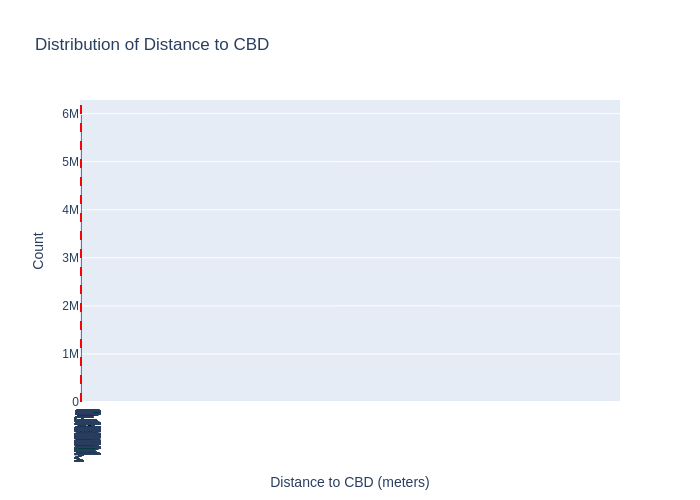

In [ ]:
distances = data['distance_to_cbd'].astype(int).dropna()

fig = px.histogram(
    distances,
    nbins=1000,
    title='Distribution of Distance to CBD ',
    labels={'value': 'Distance to CBD (meters)'},
    color_discrete_sequence=['steelblue']
)

fig.update_layout(
    xaxis_title='Distance to CBD (meters)',
    yaxis_title='Count',
    showlegend=False,
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=500
    )
)

fig.add_vline(x=1500, line_dash="dash", line_color="red")

fig.show(renderer='png')


In [ ]:
threshold = 1500

data['is_far_from_cbd'] = data.apply(
    lambda row: None if row['in_central_area'] == 1
    else int(row['distance_to_cbd'] > threshold),
    axis=1
)

In [ ]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,start_LONGITUDE,start_distance_to_start_bstop,end_bus_stop_id,end_OBJECTID,end_LATITUDE,end_LONGITUDE,end_distance_to_end_bstop,in_central_area,distance_to_cbd,is_far_from_cbd
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59.000,2024-01-25 15:52:35.000,1st & O St NW,31519.00,1st & L St NW,31677.00,38.91,-77.01,...,-77.01,669.01,54.00,55.00,38.90,-77.01,238.09,0,479.50,0.00
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58.000,2024-01-02 16:53:25.000,1st & O St NW,31519.00,4th & College St NW,31138.00,38.91,-77.01,...,-77.01,669.01,27.00,28.00,38.92,-77.01,614.84,0,1861.05,1.00
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15.000,2024-01-24 15:43:55.000,1st & O St NW,31519.00,1st & L St NW,31677.00,38.91,-77.01,...,-77.01,669.01,54.00,55.00,38.90,-77.01,238.09,0,479.50,0.00
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00.000,2024-01-04 15:37:35.000,1st & O St NW,31519.00,1st & L St NW,31677.00,38.91,-77.01,...,-77.01,669.01,54.00,55.00,38.90,-77.01,238.09,0,479.50,0.00
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58.000,2024-01-05 12:35:40.000,1st & O St NW,31519.00,10th & G St NW,31274.00,38.91,-77.01,...,-77.01,674.49,76.00,77.00,38.90,-77.03,147.29,1,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5992990,ED752EEB0386E080,electric_bike,2024-12-17 15:07:44.399,2024-12-17 15:09:43.455,West Hyattsville Metro,32418.00,West Hyattsville Metro,32418.00,38.96,-76.97,...,-77.00,1901.53,1.00,2.00,38.95,-77.00,2907.82,0,6905.33,1.00
5992991,C41F65B9CBB5C9D3,electric_bike,2024-12-17 15:22:17.220,2024-12-17 15:26:31.494,Takoma Metro,31408.00,3rd & Underwood St NW,31413.00,38.98,-77.02,...,-77.00,524.86,87.00,88.00,38.89,-76.98,900.45,0,6405.16,1.00
5992992,A8583D287950A02C,electric_bike,2024-12-17 14:37:01.467,2024-12-17 14:42:36.956,3rd & Underwood St NW,31413.00,Takoma Metro,31408.00,38.97,-77.02,...,-77.01,126.30,87.00,88.00,38.89,-76.98,983.53,0,6961.94,1.00
5992993,FAAF8885A18F1244,electric_bike,2024-12-17 15:37:10.180,2024-12-17 15:43:27.657,8th & O St NW,31281.00,8th & O St NW,31281.00,38.91,-77.02,...,-77.03,499.35,8.00,9.00,38.94,-76.99,5992.11,0,567.66,0.00


#### 3.5.7. Geohashing
* Apply geohashing to trip start/end locations (choose and justify precision).
* Categorize geohashed sectors based on average daily trips (red, yellow, gray). Define and justify thresholds.

In [ ]:
def geohash_to_polygon(geohash):
    lat, lon = pgh.decode(geohash)
    error_lat = pgh.decode_exactly(geohash)[2]
    error_lon = pgh.decode_exactly(geohash)[3]

    min_lat = lat - error_lat
    max_lat = lat + error_lat
    min_lon = lon - error_lon
    max_lon = lon + error_lon

    return box(min_lon, min_lat, max_lon, max_lat)


In [ ]:

def create_geohash(lat, lon, precision=6):
    return pgh.encode(lat, lon, precision=precision)


In [ ]:
data['geohash_start'] = data.apply(
    lambda row: create_geohash(row['start_lat'], row['start_lng']), axis=1
)
data['geohash_end'] = data.apply(
    lambda row: create_geohash(row['end_lat'], row['end_lng']), axis=1
)

all_geohashes = pd.concat([
    data['geohash_start'],
    data['geohash_end']
]).reset_index(drop=True)

sector_counts = all_geohashes.value_counts().reset_index()
sector_counts.columns = ['geohash', 'total_trips']


geometry = [geohash_to_polygon(g) for g in sector_counts['geohash']]
gdf = gpd.GeoDataFrame(sector_counts, geometry=geometry, crs="EPSG:4326")


red_threshold = gdf['total_trips'].quantile(0.90)
yellow_threshold = gdf['total_trips'].quantile(0.60)

In [ ]:
def classify(count):
    if count >= red_threshold:
        return 'Red'
    elif count > yellow_threshold:
        return 'Yellow'
    else:
        return 'Gray'

gdf['category'] = gdf['total_trips'].apply(classify)


In [ ]:
fig = px.choropleth_mapbox(
    gdf,
    geojson=gdf.geometry,
    locations=gdf.index,
    color='category',
    color_discrete_map={
        'Red': '#d62728',     # أحمر داكن
        'Yellow': '#ffbb33',  # أصفر لامع
        'Gray': '#808080'     # رمادي
    },
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 38.90, "lon": -77.03},  # مركز واشنطن دي سي
    opacity=0.5,
    title="Distribution of Geographic Sectors by Density (as Polygons)",
    hover_data=['total_trips']
)

fig.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    dragmode=False,  # تعطيل التفاعل
    showlegend=True,
    width=1000,
    height=800
)

fig.show(renderer='png')

fig.write_html("geohash_sectors_as_polygons.html")

In [ ]:
data = data.merge(
    gdf[['geohash', 'category']],
    how='left',
    left_on='geohash_start',
    right_on='geohash',
    suffixes=('', '_start')
).rename(columns={'category': 'category_start'}).drop(columns=['geohash'])

data = data.merge(
    gdf[['geohash', 'category']],
    how='left',
    left_on='geohash_end',
    right_on='geohash',
    suffixes=('', '_end')
).rename(columns={'category': 'category_end'}).drop(columns=['geohash'])

def trip_category(row):
    categories = [row['category_start'], row['category_end']]
    if 'Red' in categories:
        return 'Red'
    elif 'Yellow' in categories:
        return 'Yellow'
    else:
        return 'Gray'

data['trip_category'] = data.apply(trip_category, axis=1)


#### 3.5.8. Weather Condition Binning
* Bin weather status into 'sunny', 'cloudy', 'rainy'.

In [ ]:
data["conditions"].unique()

In [ ]:
def categorize_weather(condition):
    if 'Rain' in condition:
        return 'Rain'
    elif 'Overcast' in condition or 'cloudy' in condition:
        return 'Overcast'
    elif 'Clear' in condition:
        return 'Clear'

data['weather_category'] = data['conditions'].apply(categorize_weather)


#### 3.5.9. Daily Revenue Time Series
* Create a time series of total daily revenue (payment day is trip end date), including weather status.

In [ ]:
# Create daily revenue time series

In [ ]:

data['end_date'] = data['ended_at'].dt.date

daily_revenue = data.groupby('end_date')['total_cost'].sum().reset_index()
daily_revenue.rename(columns={'end_date': 'date', 'total_cost': 'daily_revenue'}, inplace=True)

daily_weather = data.groupby('end_date')['weather_category'] \
                      .agg(lambda x: x.mode()[0] if not x.mode().empty else None) \
                      .reset_index()
daily_weather.rename(columns={'end_date': 'date'}, inplace=True)


daily_summary = pd.merge(daily_revenue, daily_weather, on='date', how='left')


daily_trips_count = data.groupby('end_date').size().reset_index(name='trip_count')

daily_trips_count.rename(columns={'end_date': 'date'}, inplace=True)
daily_summary = pd.merge(daily_summary, daily_trips_count, on='date', how='left')


daily_summary['cumulative_revenue'] = daily_summary['daily_revenue'].cumsum()
daily_summary.head(10)

,date,daily_revenue,weather_category,trip_count,cumulative_revenue
0,2024-01-01,6200.27,Rain,1557,6200.27
1,2024-01-02,10585.61,Overcast,2518,16785.88
2,2024-01-03,11472.50,Overcast,2926,28258.38
3,2024-01-04,10886.09,Overcast,2732,39144.47
4,2024-01-05,10471.57,Overcast,2717,49616.04
5,2024-01-06,3988.44,Rain,1009,53604.48
6,2024-01-07,10278.80,Overcast,2664,63883.28
7,2024-01-08,12641.69,Overcast,3203,76524.97
8,2024-01-09,4330.75,Rain,1079,80855.72
9,2024-01-10,13557.72,Rain,3408,94413.44


In [ ]:
daily_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                366 non-null    object 
 1   daily_revenue       366 non-null    float64
 2   weather_category    366 non-null    object 
 3   trip_count          366 non-null    int64  
 4   cumulative_revenue  366 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 14.4+ KB


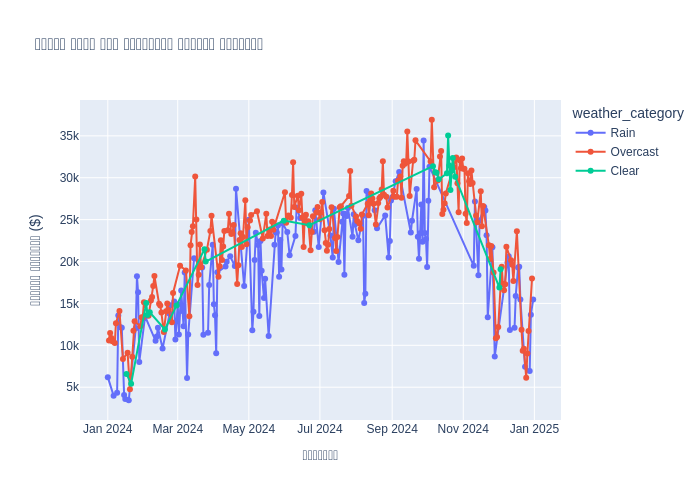

In [ ]:
fig = px.line(daily_summary, x='date', y='daily_revenue', color='weather_category',
              title='Total Daily Revenue by Weather Condition',
              labels={'daily_revenue': 'Daily Revenue ($)', 'date': 'Date'},
              markers=True)
fig.show(renderer='png')

In [ ]:
daily_summary.to_csv('/content/drive/MyDrive/Data Mining Homework/AllData/daily_summary.csv', index=False)
data.drop(columns=['end_date'])

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_EGIS_ID,end_BSTP_LON,end_BSTP_LAT,end_distance_to_end_bstop,in_central_area,distance_to_cbd,is_far_from_cbd,geohash_start,geohash_end,weather_category
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37.000,2024-05-04 14:37:52.000,14th & G St NW,31238.00,Jefferson Memorial,31249.00,38.90,-77.03,...,1307337.00,-77.03,38.89,878.19,1,735.64,NaN,dqcjr1,dqcjnv,Rain
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53.000,2024-05-04 15:00:25.000,Jefferson Dr & 14th St SW,31247.00,7th & F St NW / National Portrait Gallery,31232.00,38.89,-77.03,...,1307266.00,-77.02,38.90,60.94,1,0.00,NaN,dqcjpp,dqcjr3,Rain
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21.000,2024-05-04 15:27:29.000,1st & M St NE,31603.00,4th & M St SW,31108.00,38.91,-77.01,...,1311406.00,-77.02,38.88,35.06,0,756.18,0.00,dqcjrd,dqcjpm,Rain
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59.000,2024-05-04 14:54:11.000,Jefferson Memorial,31249.00,Hains Point/Buckeye & Ohio Dr SW,31273.00,38.88,-77.04,...,1395460.00,-77.02,38.88,587.71,0,638.18,0.00,dqcjnv,dqcjpj,Rain
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20.000,2024-05-04 19:41:35.000,New Hampshire Ave & T St NW,31229.00,14th & G St NW,31238.00,38.92,-77.04,...,1307112.00,-77.03,38.90,39.57,1,0.00,NaN,dqcjqu,dqcjr1,Rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978485,23FA8A5317DDACB1,electric_bike,2024-01-03 16:46:10.000,2024-01-03 16:48:37.000,Grant Circle,31421.00,Park Rd & Holmead Pl NW,31602.00,38.94,-77.02,...,1301764.00,-77.03,38.93,117.12,0,2339.29,1.00,dqcjx3,dqcjrp,Overcast
1978486,2270D408C60E9429,electric_bike,2024-01-03 20:02:17.000,2024-01-03 20:27:12.000,8th & O St NW,31281.00,13th St & New York Ave NW,31227.00,38.91,-77.02,...,1307450.00,-77.03,38.90,55.46,1,0.00,NaN,dqcjr7,dqcjr1,Overcast
1978487,613569D499A23645,electric_bike,2024-09-16 00:31:22.700,2024-09-16 00:51:59.523,The Mall at Prince Georges,32422.00,Baltimore Ave & Van Buren St / Riverdale Park ...,32402.00,38.97,-76.95,...,1395421.00,-76.94,38.97,94.38,0,9787.59,1.00,dqcm8y,dqcm9n,Overcast
1978488,79C0AF145131E7AB,electric_bike,2024-09-16 16:49:19.676,2024-09-16 16:57:20.375,Georgia Ave & Morton St NW,31419.00,13th & O St NW/ Logan Circle,31311.00,38.93,-77.02,...,1307502.00,-77.03,38.91,104.69,0,359.92,0.00,dqcjrr,dqcjr5,Overcast


#### 3.5.10. Other Custom Features
* Document any other features created to aid exploration or integration.

In [ ]:
# Create any other custom features

### 3.6. Final Dataset Check
* Review the merged and augmented dataset for consistency, completeness, and correctness.

In [ ]:
# Perform final check on the processed DataFrame

In [ ]:

data.isnull().sum()
data.to_csv('/content/drive/MyDrive/Data Mining Homework/AllData/final_data.csv', index=False)

## 4. Exploratory Data Analysis (EDA)

*For each visualization, provide an interpretation of what the chart shows and any insights derived in a markdown cell below the code cell producing the chart.*

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Data Mining Homework/AllData/final_data.csv')
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_BSTP_LON.1,end_BSTP_LAT.1,end_distance_to_end_bstop,in_central_area,distance_to_cbd,is_far_from_cbd,geohash_start,geohash_end,weather_category,end_date
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37.000,2024-05-04 14:37:52.000,14th & G St NW,31238.00,Jefferson Memorial,31249.00,38.90,-77.03,...,-77.03,38.89,878.19,1,735.64,NaN,dqcjr1,dqcjnv,Rain,2024-05-04
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53.000,2024-05-04 15:00:25.000,Jefferson Dr & 14th St SW,31247.00,7th & F St NW / National Portrait Gallery,31232.00,38.89,-77.03,...,-77.02,38.90,60.94,1,0.00,NaN,dqcjpp,dqcjr3,Rain,2024-05-04
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21.000,2024-05-04 15:27:29.000,1st & M St NE,31603.00,4th & M St SW,31108.00,38.91,-77.01,...,-77.02,38.88,35.06,0,756.18,0.00,dqcjrd,dqcjpm,Rain,2024-05-04
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59.000,2024-05-04 14:54:11.000,Jefferson Memorial,31249.00,Hains Point/Buckeye & Ohio Dr SW,31273.00,38.88,-77.04,...,-77.02,38.88,587.71,0,638.18,0.00,dqcjnv,dqcjpj,Rain,2024-05-04
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20.000,2024-05-04 19:41:35.000,New Hampshire Ave & T St NW,31229.00,14th & G St NW,31238.00,38.92,-77.04,...,-77.03,38.90,39.57,1,0.00,NaN,dqcjqu,dqcjr1,Rain,2024-05-04


In [ ]:
daily_summary=pd.read_csv('/content/drive/MyDrive/Data Mining Homework/AllData/daily_summary.csv')
daily_summary.head()

,date,daily_revenue,weather_category,trip_count,cumulative_revenue
0,2024-01-01,6200.27,Rain,1557,6200.27
1,2024-01-02,10585.61,Overcast,2518,16785.88
2,2024-01-03,11472.50,Overcast,2926,28258.38
3,2024-01-04,10886.09,Overcast,2732,39144.47
4,2024-01-05,10471.57,Overcast,2717,49616.04


In [ ]:
daily_weather_metrics = data.groupby('end_date').agg(
    temp_avg=('temp', 'first'),
    windspeed_avg=('windspeedmean', 'first'),
    humidity=('humidity', 'first')
).reset_index()

daily_weather_metrics.rename(columns={'end_date': 'date'}, inplace=True)
# 3. دمج البيانات مع daily_summary
daily_summary = pd.merge(daily_summary, daily_weather_metrics, on='date', how='left')

# 4. عرض أول صفوف الجدول للتحقق
daily_summary.head ()

,date,daily_revenue,weather_category,trip_count,cumulative_revenue,temp_avg,windspeed_avg,humidity
0,2024-01-01,6200.27,Rain,1557,6200.27,4.9,11.9,74.7
1,2024-01-02,10585.61,Overcast,2518,16785.88,4.7,18.6,57.3
2,2024-01-03,11472.50,Overcast,2926,28258.38,4.4,8.9,59.5
3,2024-01-04,10886.09,Overcast,2732,39144.47,4.7,17.0,55.2
4,2024-01-05,10471.57,Overcast,2717,49616.04,0.9,10.6,55.0


### 4.1. Bike and Station Analysis

#### 4.1.1. Top 5 busiest start stations (Bar chart).

In [ ]:
!plotly_get_chrome


Plotly will install a copy of Google Chrome to be used for generating static images of plots.
Chrome will be installed at: /usr/local/lib/python3.11/dist-packages/choreographer/cli/browser_exe
Do you want to proceed? [y/n] y
Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.11/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


busiest start stations:start_station_name
Park Rd & Holmead Pl NW          26438
14th & Belmont St NW             21315
18th St & Wyoming Ave NW         20893
5th St & Massachusetts Ave NW    18331
17th & P St NW                   18296
Name: count, dtype: int64


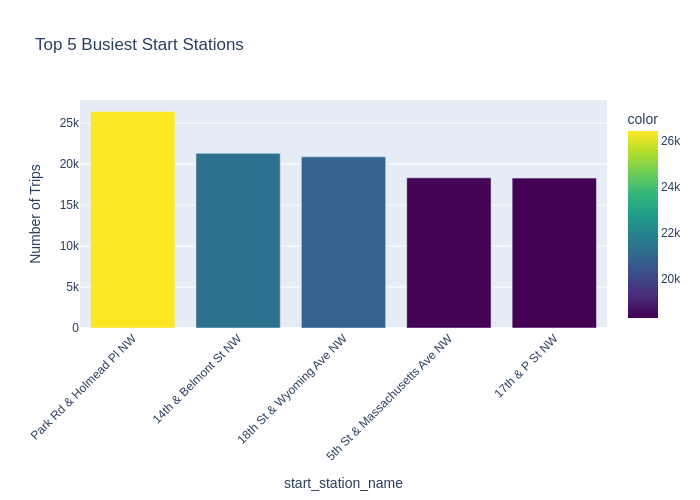

In [ ]:
import plotly.io as pio

# Calculate the top 5 busiest start stations
busiest_start_stations = data['start_station_name'].value_counts().head(5)
print(f"busiest start stations:{busiest_start_stations}")

# Create a bar chart
fig = px.bar(
    busiest_start_stations,
    x=busiest_start_stations.index,
    y=busiest_start_stations.values,
    title='Top 5 Busiest Start Stations',
    labels={'x': 'Start Station Name', 'y': 'Number of Trips'},
    color=busiest_start_stations.values,
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(xaxis_tickangle=-45)

# Save as static image (non-interactive)
pio.show(fig, renderer="png")


*(Interpretation for 4.1.1)*

#### 4.1.2. Trip distribution by bike type and subscription type (Bar chart).

Trip distribution:    rideable_type member_casual  trip_count
0   classic_bike        casual      310256
1   classic_bike        member      577737
2  electric_bike        casual      353707
3  electric_bike        member      736790


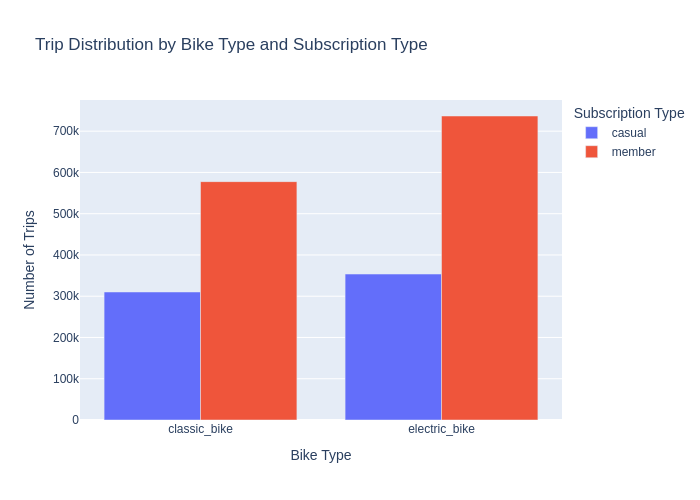

In [ ]:
# Group data by bike type and subscription type and count the number of trips
trip_distribution = data.groupby(['rideable_type', 'member_casual']).size().reset_index(name='trip_count')
print(f"Trip distribution: {trip_distribution}")

# Create a grouped bar chart
fig = px.bar(
    trip_distribution,
    x='rideable_type',
    y='trip_count',
    color='member_casual',
    barmode='group',
    title='Trip Distribution by Bike Type and Subscription Type',
    labels={'rideable_type': 'Bike Type', 'trip_count': 'Number of Trips', 'member_casual': 'Subscription Type'}
)

pio.show(fig, renderer="png")

*(Interpretation for 4.1.2)*

#### 4.1.3. Trip distribution by bike type and subscription type for the top 5 start stations (Sunburst chart).

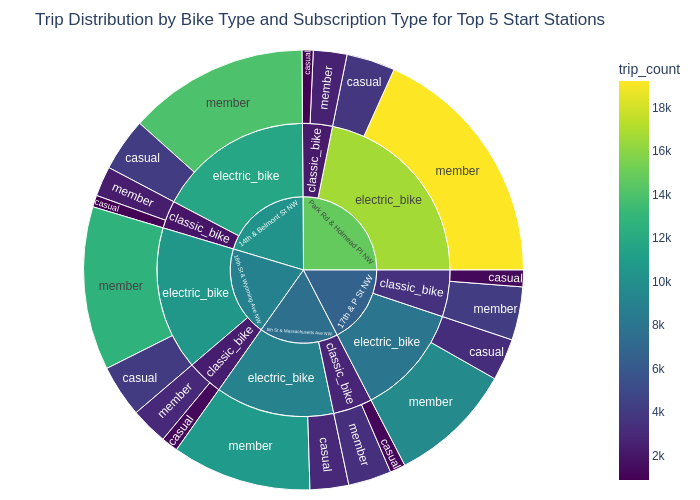

In [ ]:
# Get the top 5 busiest start stations
top_5_start_stations = data['start_station_name'].value_counts().head(5).index.tolist()

# Filter the DataFrame to include only trips from these top 5 stations
filtered_data = data[data['start_station_name'].isin(top_5_start_stations)].copy()

# Group by start station, bike type, and subscription type
sunburst_data = filtered_data.groupby(['start_station_name', 'rideable_type', 'member_casual']).size().reset_index(name='trip_count')

# Create the sunburst chart
fig = px.sunburst(
    sunburst_data,
    path=['start_station_name', 'rideable_type', 'member_casual'], # Define the hierarchy levels
    values='trip_count',
    title='Trip Distribution by Bike Type and Subscription Type for Top 5 Start Stations',
    color='trip_count',  # Color based on the number of trips
    color_continuous_scale='Viridis'
)

fig.update_layout(margin=dict(t=50, l=10, r=10, b=10))

pio.show(fig, renderer="png")

*(Interpretation for 4.1.3)*

#### 4.1.4. Distribution of bike station capacities (Histogram).

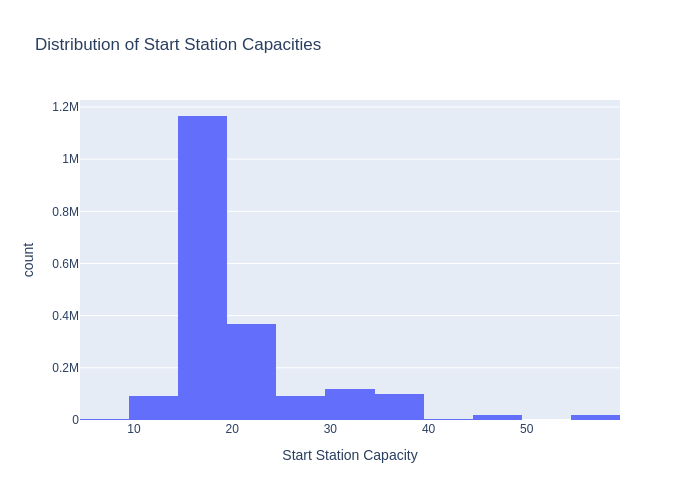

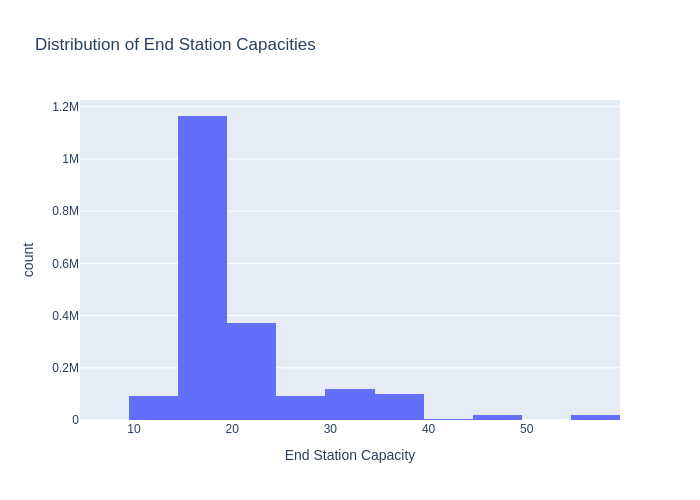

In [ ]:
fig = px.histogram(
    data,
    x='start_CAPACITY',
    nbins=20,
    title="Distribution of Start Station Capacities",
    labels={'start_CAPACITY': 'Start Station Capacity', 'count': 'Frequency'}
)
pio.show(fig, renderer="png")

# 2. Histogram لتوزع سعة محطات النهاية
fig = px.histogram(
    data,
    x='end_CAPACITY',
    nbins=20,
    title="Distribution of End Station Capacities",
    labels={'end_CAPACITY': 'End Station Capacity', 'count': 'Frequency'}
)
pio.show(fig, renderer="png")

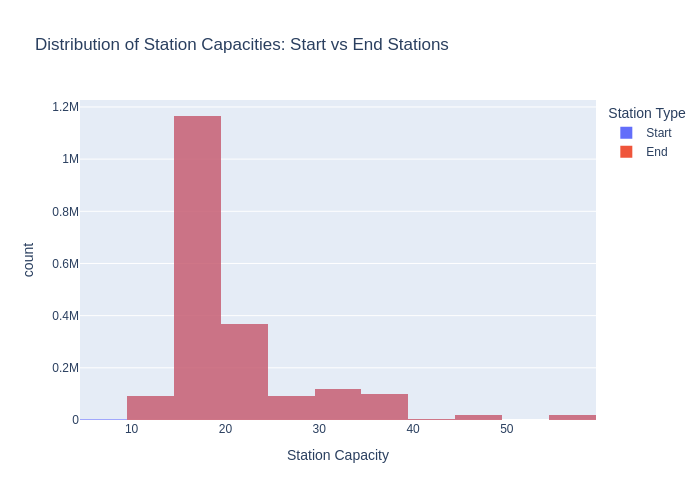

In [ ]:
import plotly.express as px
import pandas as pd

# إنشاء DataFrame جديد ببيانات "Capacity" بطريقة طويلة (long format)
capacity_data = pd.DataFrame({
    'Capacity': pd.concat([data['start_CAPACITY'], data['end_CAPACITY']], ignore_index=True),
    'Type': ['Start'] * len(data) + ['End'] * len(data)
})

# رسم هيستوغرام مزدوج
fig = px.histogram(
    capacity_data,
    x='Capacity',
    color='Type',  # لتفرقة بين Start و End
    nbins=20,
    title="Distribution of Station Capacities: Start vs End Stations",
    labels={'Capacity': 'Station Capacity', 'count': 'Frequency'},
    barmode='overlay',  # وضع الأعمدة فوق بعضها
    opacity=0.6  # لجعلها مرئية معًا
)

fig.update_layout(
    legend_title_text='Station Type'
)

pio.show(fig, renderer="png")

*(Interpretation for 4.1.4)*

#### 4.1.5. Trip distribution by start and end station capacity category (Bar chart).

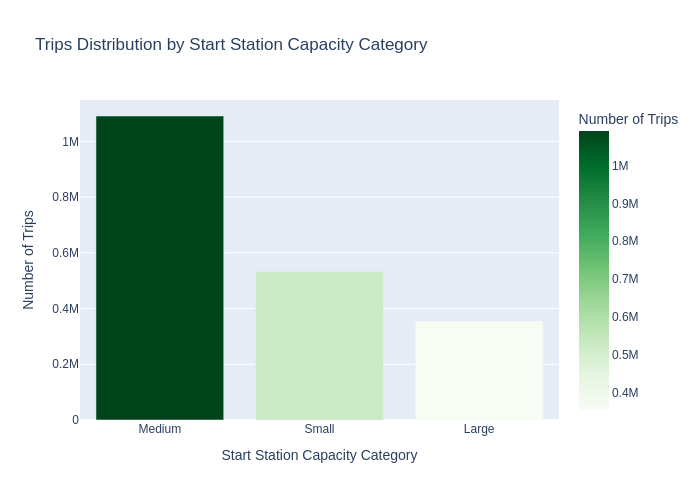

In [ ]:
start_capacity_dist = data['start_capacity_cat_cut'].value_counts().reset_index()
start_capacity_dist.columns = ['Capacity Category', 'Count']

fig = px.bar(
    start_capacity_dist,
    x='Capacity Category',
    y='Count',
    title="Trips Distribution by Start Station Capacity Category",
    labels={'Capacity Category': 'Start Station Capacity Category', 'Count': 'Number of Trips'},
    color='Count',
    color_continuous_scale='Greens'
)
pio.show(fig, renderer="png")

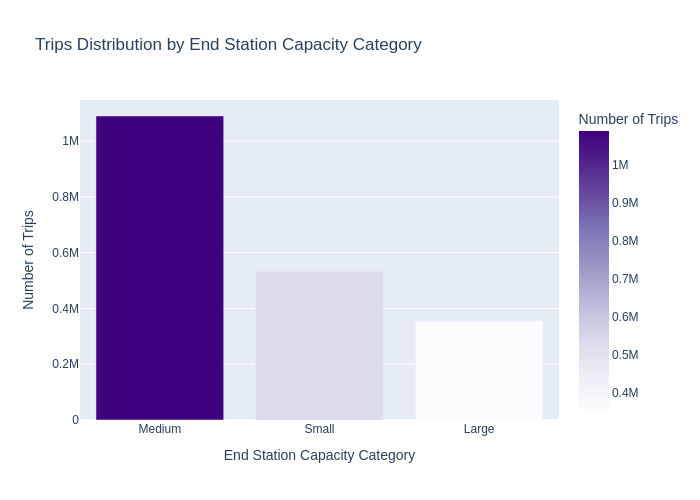

In [ ]:

end_capacity_dist = data['end_capacity_cat'].value_counts().reset_index()
end_capacity_dist.columns = ['Capacity Category', 'Count']

fig = px.bar(
    end_capacity_dist,
    x='Capacity Category',
    y='Count',
    title="Trips Distribution by End Station Capacity Category",
    labels={'Capacity Category': 'End Station Capacity Category', 'Count': 'Number of Trips'},
    color='Count',
    color_continuous_scale='Purples'
)
pio.show(fig, renderer="png")

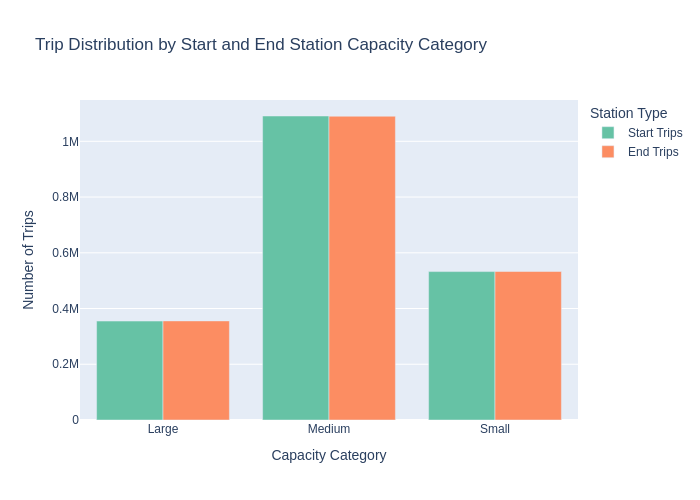

In [ ]:
import pandas as pd
import plotly.express as px

# 1. تحديد التوزيع لمحطات الانطلاق
start_capacity_dist = data['start_capacity_cat_cut'].value_counts().reset_index()
start_capacity_dist.columns = ['Capacity Category', 'Start Trips']

# 2. تحديد التوزيع لمحطات النهاية
end_capacity_dist = data['end_capacity_cat'].value_counts().reset_index()
end_capacity_dist.columns = ['Capacity Category', 'End Trips']

# 3. دمج البيانات
combined_capacity_dist = pd.merge(
    start_capacity_dist,
    end_capacity_dist,
    on='Capacity Category',
    how='outer'
)

# 4. تحويل البيانات إلى الشكل الطويل (long format)
combined_long = combined_capacity_dist.melt(
    id_vars='Capacity Category',
    value_vars=['Start Trips', 'End Trips'],
    var_name='Station Type',
    value_name='Number of Trips'
)

# 5. رسم المخطط الشريطي المجمّع
fig = px.bar(
    combined_long,
    x='Capacity Category',
    y='Number of Trips',
    color='Station Type',
    barmode='group',
    title="Trip Distribution by Start and End Station Capacity Category",
    labels={
        'Capacity Category': 'Capacity Category',
        'Number of Trips': 'Number of Trips',
        'Station Type': 'Station Type'
    },
    color_discrete_sequence=px.colors.qualitative.Set2  # ألوان جذابة
)

fig.update_layout(
    legend_title_text='Station Type',
    xaxis_title='Capacity Category',
    yaxis_title='Number of Trips'
)

pio.show(fig, renderer="png")

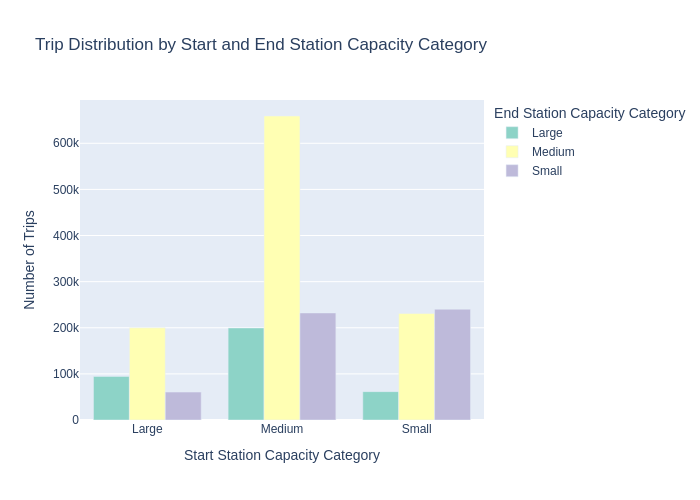

In [ ]:
import pandas as pd
import plotly.express as px

# تجميع البيانات بناءً على start_capacity_category و end_capacity_category
grouped_data = data.groupby(['start_capacity_cat_cut', 'end_capacity_cat']).size().reset_index(name='Count')

# تغيير أسماء الأعمدة للوضوح
grouped_data.columns = ['Start Capacity Category', 'End Capacity Category', 'Number of Trips']

# رسم المخطط الشريطي المجمّع
fig = px.bar(
    grouped_data,
    x='Start Capacity Category',
    y='Number of Trips',
    color='End Capacity Category',
    barmode='group',
    title="Trip Distribution by Start and End Station Capacity Category",
    labels={
        'Start Capacity Category': 'Start Station Capacity Category',
        'End Capacity Category': 'End Station Capacity Category',
        'Number of Trips': 'Number of Trips'
    },
    color_discrete_sequence=px.colors.qualitative.Set3  # ألوان جذابة
)

fig.update_layout(
    legend_title_text='End Station Capacity Category',
    xaxis_title='Start Station Capacity Category',
    yaxis_title='Number of Trips'
)
pio.show(fig, renderer="png")

*(Interpretation for 4.1.5)*

### 4.2. Trip Duration Analysis

#### 4.2.1. Distribution of trip duration in minutes (Histogram, choose appropriate bins).

In [ ]:
data["duration_minutes"].describe()

,duration_minutes
count,1978490.00
mean,15.49
std,31.09
min,1.00
25%,5.80
50%,9.94
75%,16.98
max,1559.93


Suggested number of bins: 71


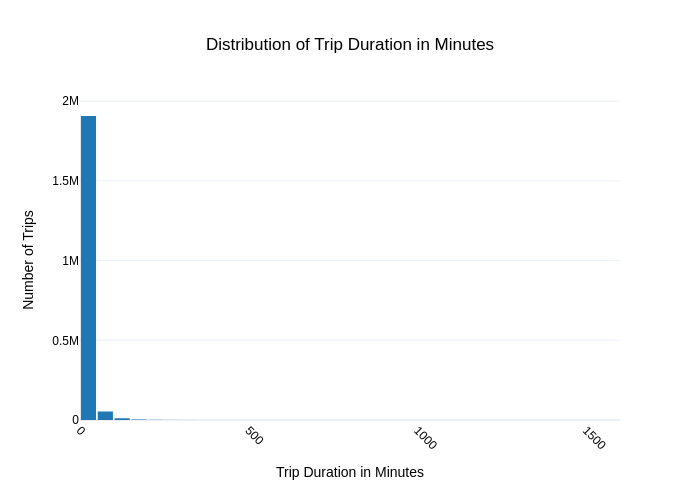

In [ ]:
from IPython.display import display, Image

bin_count = int((data["duration_minutes"].max() - data["duration_minutes"].min()) /
                (1 + 3.3 * np.log10(len(data["duration_minutes"]))))
print(f"Suggested number of bins: {bin_count}")
fig = px.histogram(
    data,
    x='duration_minutes',
    nbins=bin_count,
    title='Distribution of Trip Duration in Minutes',
    labels={'duration_minutes': 'Trip Duration in Minutes', 'count': 'Number of Trips'},
    color_discrete_sequence=['#1f77b4']
)
fig.update_layout(
    xaxis_title='Trip Duration in Minutes',
    yaxis_title='Number of Trips',
    title_x=0.5,
    bargap=0.1,
    width=1000,
    height=600,
    font=dict(family="Arial", size=12, color="black"),
    xaxis=dict(tickangle=45),
    template='plotly_white'
)
fig.write_image("duration_distribution.png")
display(Image(filename='duration_distribution.png'))

*(Interpretation for 4.2.1)*

#### 4.2.2. Trip duration distribution by bike type (Box plot).

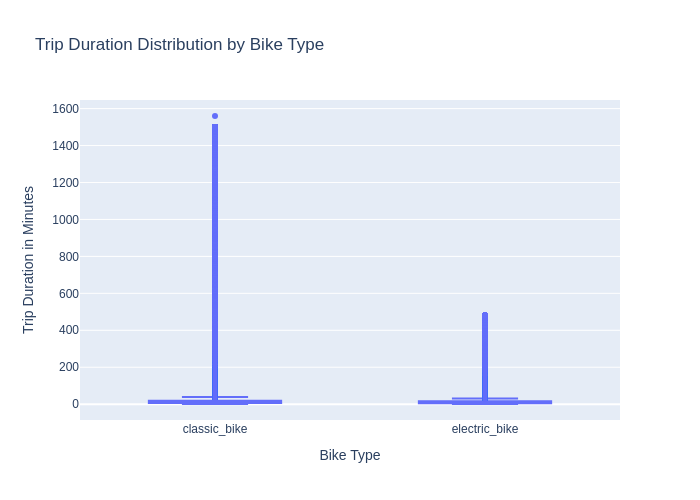

In [ ]:

fig = px.box(
    data,
    x='rideable_type',
    y='duration_minutes',
    title='Trip Duration Distribution by Bike Type',
    labels={'rideable_type': 'Bike Type', 'duration_minutes': 'Trip Duration in Minutes'}
)
fig.update_layout(
    xaxis_title='Bike Type',
    yaxis_title='Trip Duration in Minutes'
)
fig.write_image("duration_distribution_by_bike_type.png")
display(Image(filename='duration_distribution_by_bike_type.png'))

*(Interpretation for 4.2.2)*

#### 4.2.3. Trip duration distribution by subscription type (Box plot).

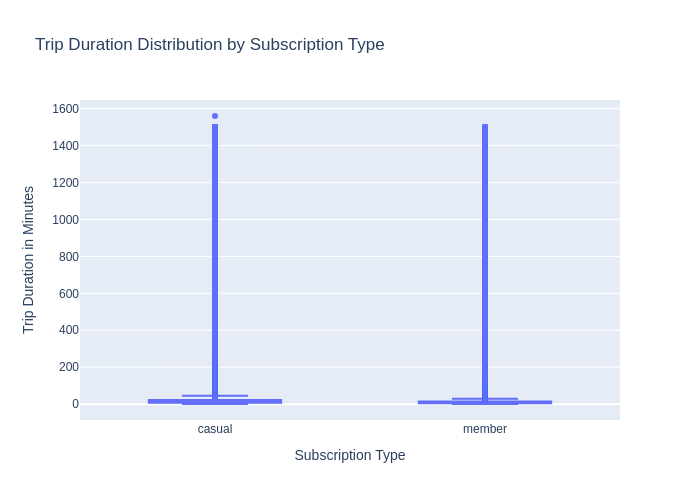

In [ ]:
fig = px.box(
    data,
    x='member_casual',
    y='duration_minutes',
    title='Trip Duration Distribution by Subscription Type',
    labels={'member_casual': 'Subscription Type', 'duration_minutes': 'Trip Duration in Minutes'}
)
fig.update_layout(
    xaxis_title='Subscription Type',
    yaxis_title='Trip Duration in Minutes'
)
fig.write_image("duration_distribution_by_subscription_type.png")
display(Image(filename='duration_distribution_by_subscription_type.png'))

*(Interpretation for 4.2.3)*

#### 4.2.4. Map of stations showing trips exceeding one day (Folium map, point size based on count).

/tmp/ipython-input-221-3464424025.py:29: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



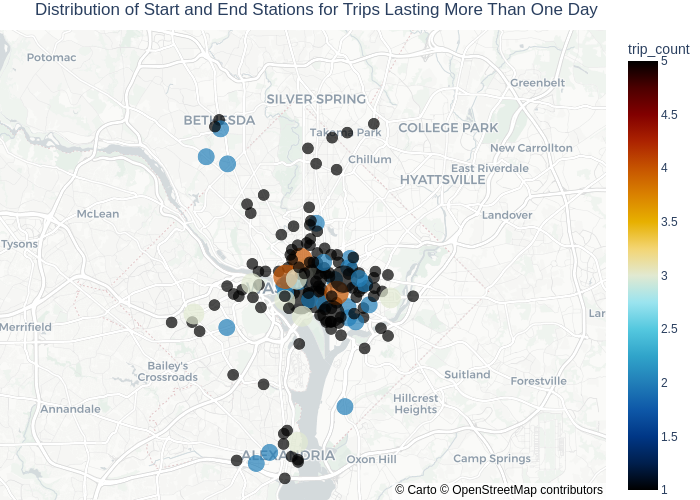

In [ ]:
from collections import Counter
import pandas as pd
import plotly.express as px
from IPython.display import Image

long_trips = data[data['duration_minutes'] > 1440]

start_coords = long_trips[['start_lat', 'start_lng']].dropna()
end_coords = long_trips[['end_lat', 'end_lng']].dropna()

start_coords.columns = ['lat', 'lon']
end_coords.columns = ['lat', 'lon']

all_coords = pd.concat([start_coords, end_coords], ignore_index=True)

def round_coords(row, precision=4):
    return (round(row['lat'], precision), round(row['lon'], precision))

all_coords['rounded'] = all_coords.apply(round_coords, axis=1)


coord_counter = Counter(all_coords['rounded'])

coord_counts = pd.DataFrame(list(coord_counter.items()), columns=['coords', 'trip_count'])
coord_counts[['lat', 'lon']] = pd.DataFrame(coord_counts['coords'].tolist(), index=coord_counts.index)
coord_counts.drop('coords', axis=1, inplace=True)


fig = px.scatter_mapbox(
    coord_counts,
    lat="lat",
    lon="lon",
    size="trip_count",
    color="trip_count",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=20,
    zoom=10,
    center={"lat": 38.9072, "lon": -77.0369},  # مركز المدينة (مثلاً واشنطن دي سي)
    mapbox_style="carto-positron",
    hover_data={"trip_count": True}
)

fig.update_layout(
    title="Distribution of Start and End Stations for Trips Lasting More Than One Day",
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.write_image("long_trips_map_screenshot.png")
Image(filename='long_trips_map_screenshot.png')

*(Interpretation for 4.2.4)*

### 4.3. Financial Analysis

#### 4.3.1. Distribution of trip cost (Histogram and Box plot in the same figure).

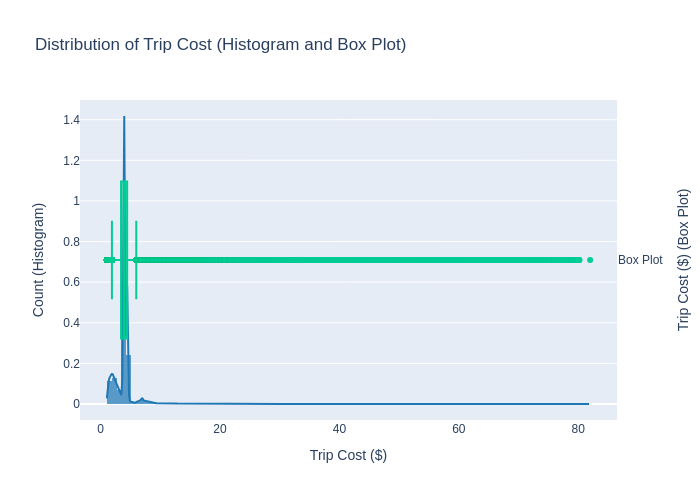

In [ ]:
import plotly.figure_factory as ff

# Your data column
trip_costs = data['total_cost']

# Set desired number of bins
n_bins = 100

# Calculate bin size
bin_size = (trip_costs.max() - trip_costs.min()) / n_bins

# Create histogram + KDE plot
fig = ff.create_distplot(
    [trip_costs],
    group_labels=['Trip Cost'],
    show_hist=True,
    show_rug=False,
    bin_size=bin_size  # Specific bin size based on n_bins
)

# Add a box plot
box_plot = go.Box(
    x=trip_costs,
    name='Box Plot',
    yaxis='y2',
    boxpoints='outliers'
)

fig.add_trace(box_plot)

# Update layout for dual y-axes
fig.update_layout(
    title='Distribution of Trip Cost (Histogram and Box Plot)',
    xaxis_title='Trip Cost ($)',
    yaxis_title='Count (Histogram)',
    yaxis2=dict(
        title='Trip Cost ($) (Box Plot)',
        overlaying='y',
        side='right'
    ),
    showlegend=False
)

# Show as static image (non-interactive)
pio.show(fig, renderer="png")


*(Interpretation for 4.3.1)*

#### 4.3.2. Trip cost vs. trip duration (Scatter plot with trend line).

In [ ]:
!pip install statsmodels

In [ ]:
%%capture
!pip install --force-reinstall kaleido==0.1.0post1

In [ ]:
from IPython.display import Image

fig = px.scatter(
    data,
    x='duration_minutes',
    y='total_cost',
    title='Trip Cost vs. Trip Duration',
    labels={'duration_minutes': 'Trip Duration (minutes)', 'total_cost': 'Trip Cost ($)'},
    trendline="ols", # Add Ordinary Least Squares trendline
)

fig.update_layout(
    xaxis_title='Trip Duration (minutes)',
    yaxis_title='Trip Cost ($)'
)

fig.write_image("trip_cost_vs_trip_duration.png")
Image(filename='trip_cost_vs_trip_duration.png')


*(Interpretation for 4.3.2)*

#### 4.3.3. Trip cost vs. temperature, colored by bike type (Scatter plot).

In [ ]:

fig = px.scatter(
    data,
    x='temp',
    y='total_cost',
    color='rideable_type', # Color points by bike type
    title='Trip Cost vs. Temperature, Colored by Bike Type',
    labels={'temp': 'Temperature (°C)', 'total_cost': 'Trip Cost ($)', 'rideable_type': 'Bike Type'}
)

fig.update_layout(
    xaxis_title='Temperature (°C)',
    yaxis_title='Trip Cost ($)',
    legend_title='Bike Type'
)

# fig.write_image("trip_cost_vs_temperature_by_bike_type.png")
# Image(filename='trip_cost_vs_temperature_by_bike_type.png')
pio.show(fig, renderer="png")

*(Interpretation for 4.3.3)*

#### 4.3.4. Time series of total daily and weekly revenue (Line chart).

In [ ]:
daily_summary['date'] = pd.to_datetime(daily_summary['date'])
daily_summary['week'] = daily_summary['date'].dt.isocalendar().week

weekly_revenue = daily_summary.groupby('week')['daily_revenue'].sum().reset_index()
weekly_revenue.rename(columns={'daily_revenue': 'weekly_revenue'}, inplace=True)

# Since weekly data doesn't have a date per row, we need to assign a date for plotting.
# We can use the start date of the week.
weekly_revenue['date'] = daily_summary.groupby('week')['date'].min().reset_index()['date']

daily_summary['date_str'] = daily_summary['date'].dt.strftime('%Y-%m-%d')
weekly_revenue['date_str'] = weekly_revenue['date'].dt.strftime('%Y-%m-%d')

fig = go.Figure()

# Add daily revenue line
fig.add_trace(go.Scatter(
    x=daily_summary['date_str'],
    y=daily_summary['daily_revenue'],
    mode='lines',
    name='Daily Revenue'
))

# Add weekly revenue line
fig.add_trace(go.Scatter(
    x=weekly_revenue['date_str'],
    y=weekly_revenue['weekly_revenue'],
    mode='lines+markers',
    name='Weekly Revenue'
))


fig.update_layout(
    title='Daily and Weekly Revenue Over Time',
    xaxis_title='Date',
    yaxis_title='Revenue ($)',
    hovermode='x unified' # Show hover info for all traces at the same x value
)

fig.show(renderer="png")

*(Interpretation for 4.3.4)*

#### 4.3.5. Time series of average monthly revenue (Line chart).

In [ ]:
monthly_revenue = daily_summary.set_index('date')['daily_revenue'].resample('ME').mean().reset_index()
monthly_revenue.rename(columns={'daily_revenue': 'average_monthly_revenue'}, inplace=True)

monthly_revenue['date_str'] = monthly_revenue['date'].dt.strftime('%Y-%m-%d')

# Create the line chart
fig = px.line(
    monthly_revenue,
    x='date_str',
    y='average_monthly_revenue',
    title='Average Monthly Revenue Time Series',
    labels={'date': 'Month', 'average_monthly_revenue': 'Average Monthly Revenue ($)'},
    markers=True # Add markers for each month
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Average Monthly Revenue ($)'
)

pio.show(fig, renderer="png")

*(Interpretation for 4.3.5)*

### 4.4. Spatial Analysis of Bike Trips

#### 4.4.1. Geographic heatmap of trip counts per residential area. Total trips outside residential areas.

In [ ]:
# Use Folium or other permitted library for heatmaps on geographic areas

In [ ]:
valid_start_zones = data[
    (data['strat_parking_zone_id'] != -1) &
    (data['strat_parking_zone_id'].notna()) &
    (data['parking_S_NAME'] != 'unknown') &
    (data['parking_S_NAME'].notna())
][['parking_S_NAME']].rename(columns={'parking_S_NAME': 'zone_name'})
valid_end_zones = data[
    (data['end_parking_zone_id'] != -1) &
    (data['end_parking_zone_id'].notna()) &
    (data['parking_E_NAME'] != 'unknown') &
    (data['parking_E_NAME'].notna())
][['parking_E_NAME']].rename(columns={'parking_E_NAME': 'zone_name'})

all_valid_zones = pd.concat([valid_start_zones, valid_end_zones], ignore_index=True)

zone_counts = all_valid_zones['zone_name'].value_counts().reset_index()
zone_counts.columns = ['zone_name', 'trip_count']

fig = px.bar(
    zone_counts,
    x='zone_name',
    y='trip_count',
    title="Number of Trips per Residential Zone",
    labels={'zone_name': 'Residential Zone', 'trip_count': 'Number of Trips'},
    color='trip_count',
    color_continuous_scale='Blues'
)

fig.update_layout(xaxis_tickangle=45)
fig.show()

out_of_residential = data[
    (
        ((data['strat_parking_zone_id'] == -1) | (data['strat_parking_zone_id'].isna()) | (data['parking_S_NAME'] == 'unknown')) &
        ((data['end_parking_zone_id'] == -1) | (data['end_parking_zone_id'].isna()) | (data['parking_E_NAME'] == 'unknown'))
    )
]

total_out_of_residential = len(out_of_residential)
print(f"\n إجمالي عدد الرحلات خارج المناطق السكنية: {total_out_of_residential}")

In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

zones_gdf = gpd.read_file("/content/drive/MyDrive/Data Mining Homework/Homework 01/data/Residential_and_Visitor_Parking_Zones.geojson")

zones_with_trips = zones_gdf.merge(zone_counts, left_on='NAME', right_on='zone_name', how='left')

zones_with_trips['trip_count'] = zones_with_trips['trip_count'].fillna(0)

In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

zones_gdf = gpd.read_file("/content/drive/MyDrive/Data Mining Homework/Homework 01/data/Residential_and_Visitor_Parking_Zones.geojson")

zones_with_trips = zones_gdf.merge(zone_counts, left_on='NAME', right_on='zone_name', how='left')

zones_with_trips['trip_count'] = zones_with_trips['trip_count'].fillna(0)
fig = px.choropleth(
    zones_with_trips,
    geojson=zones_with_trips.geometry,
    locations=zones_with_trips.index,
    color="trip_count",
    hover_data=["NAME", "trip_count"],
    color_continuous_scale="Blues",
    title="Heatmap of Trips per Residential Zone",
    labels={"trip_count": "Number of Trips"}
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(coloraxis_showscale=True, margin={"r":0,"t":40,"l":0,"b":0})
pio.show(fig, renderer="png")

*(Interpretation for 4.4.1)*

#### 4.4.2. Distribution of geohash sector categories (red, yellow, gray) (Bar chart).

In [ ]:
import plotly.express as px

# عد عدد المناطق في كل فئة
category_counts = gdf['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# رسم المخطط الشريطي
fig_bar = px.bar(
    category_counts,
    x='category',
    y='count',
    color='category',
    color_discrete_map={
        'Red': '#d62728',
        'Yellow': '#ffbb33',
        'Gray': '#808080'
    },
    labels={'category': 'الفئة', 'count': 'عدد المناطق'},
    title='توزيع فئات القطاعات الجغرافية (Geographic Hash Categories)'
)

fig_bar.update_layout(
    xaxis_title="فئة Geohash",
    yaxis_title="عدد المناطق",
    legend_title="الفئة",
    width=600,
    height=400
)

fig_bar.show(renderer='png')

In [ ]:
trip_category_counts = data['trip_category'].value_counts().reset_index()
trip_category_counts.columns = ['category', 'total_trips']

fig_trip_bar = px.bar(
    trip_category_counts,
    x='category',
    y='total_trips',
    color='category',
    color_discrete_map={
        'Red': '#d62728',
        'Yellow': '#ffbb33',
        'Gray': '#808080'
    },
    labels={'category': 'فئة الرحلة', 'total_trips': 'عدد الرحلات'},
    title='توزيع الرحلات حسب فئة القطاع الجغرافي'
)

fig_trip_bar.update_layout(
    xaxis_title="فئة الرحلة",
    yaxis_title="عدد الرحلات",
    legend_title="الفئة"
)

fig_trip_bar.show(renderer='png')

*(Interpretation for 4.4.2)*

#### 4.4.3. Distribution of distance to CBD, nearest metro, nearest bus stop (Histograms).

*(Interpretation for 4.4.3)*

#### 4.4.4. Trip distribution: entirely within CBD vs. outside CBD (Bar chart).

In [ ]:
data['all_in_central_area'] = ((data['start_in_central'] == 1) & (data['end_in_central'] == 1)).astype(int)

In [ ]:
distribution = data['all_in_central_area'].value_counts().rename(index={0: 'Outside the area', 1: 'Inside the area'})

# Plot the bar chart
fig = px.bar(
    x=distribution.index,
    y=distribution.values,
    labels={'x': 'Area', 'y': 'Number of trips'},
    title='Distribution of Trips by Location (Inside/Outside the Central Business District)'
)

pio.show(fig, renderer="png")

*(Interpretation for 4.4.4)*

#### 4.4.5. Distribution of trips passing through CBD by bike type and subscription type (Bar chart).

In [ ]:
central_trips = data[data['in_central_area'] == 1]

In [ ]:
grouped = central_trips.groupby(['member_casual', 'rideable_type']).size().reset_index(name='count')

In [ ]:
fig = px.bar(
    grouped,
    x='member_casual',
    y='count',
    color='rideable_type',
    barmode='group',
    labels={'count': 'Number of Trips', 'member_casual': 'Subscription Type', 'rideable_type': 'Bike Type'},
    title='Distribution of Trips Passing Through the Central Business District by Bike Type and Subscription Type'
)


pio.show(fig, renderer="png")

*(Interpretation for 4.4.5)*

#### 4.4.6. Chi-square test: Association between distance-to-CBD category and subscription type.

In [ ]:
# Perform Chi-square test using scipy.stats.chi2_contingency

*(Interpretation for 4.4.6)*

### 4.5. Weather Impact Analysis

#### 4.5.1. Daily average temperature, wind speed, and humidity (Line chart).

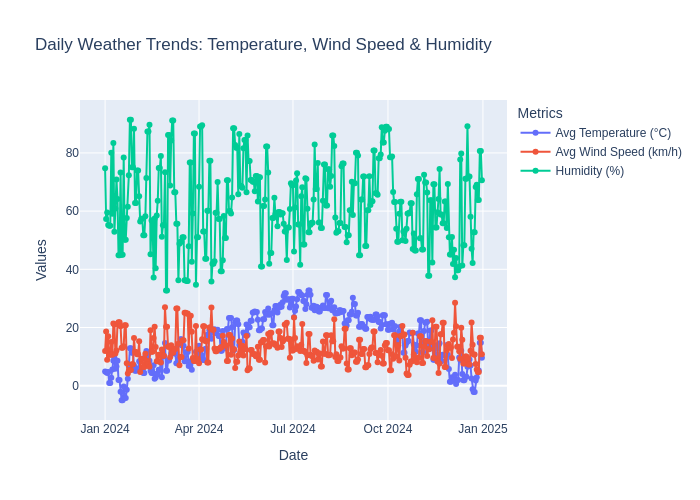

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_summary['date'], y=daily_summary['temp_avg'],
                         mode='lines+markers', name='Avg Temperature (°C)'))

fig.add_trace(go.Scatter(x=daily_summary['date'], y=daily_summary['windspeed_avg'],
                         mode='lines+markers', name='Avg Wind Speed (km/h)'))

fig.add_trace(go.Scatter(x=daily_summary['date'], y=daily_summary['humidity'],
                         mode='lines+markers', name='Humidity (%)'))

fig.update_layout(
    title="Daily Weather Trends: Temperature, Wind Speed & Humidity",
    xaxis_title="Date",
    yaxis_title="Values",
    legend_title="Metrics"
)

pio.show(fig, renderer="png")

*(Interpretation for 4.5.1)*

#### 4.5.2. Daily revenue by weather condition (sunny, cloudy, rainy) (Box plot).

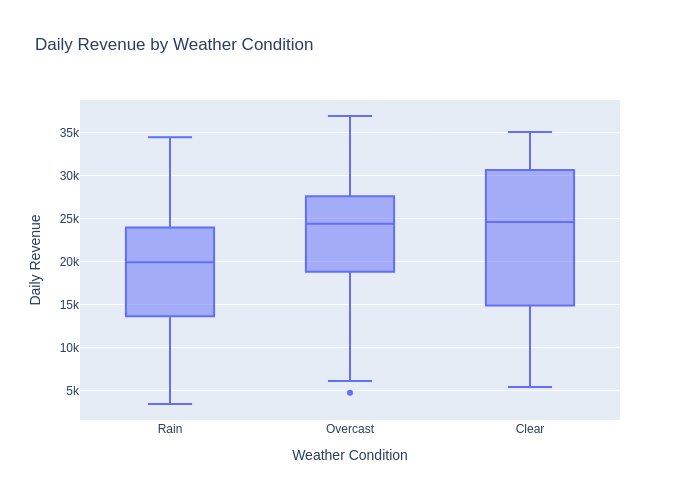

In [ ]:
fig = px.box(
    daily_summary,
    x='weather_category',
    y='daily_revenue',
    title='Daily Revenue by Weather Condition',
    labels={'weather_category': 'Weather Condition', 'daily_revenue': 'Daily Revenue'}
)
pio.show(fig, renderer="png")

*(Interpretation for 4.5.2)*

#### 4.5.3. Linear correlation between temperature, humidity, and daily revenue (Correlation matrix/heatmap, scatter plots).

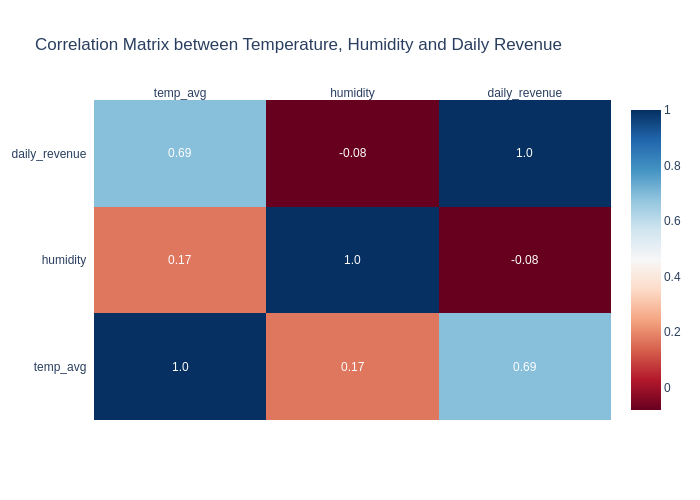

In [ ]:
import plotly.figure_factory as ff
import numpy as np

# تحديد المتغيرات المراد تحليلها
correlation_data = daily_summary[['temp_avg', 'humidity', 'daily_revenue']].corr()

# تحويل مصفوفة الارتباط إلى صيغة مناسبة لـ Heatmap
labels = correlation_data.columns.tolist()
matrix = np.around(correlation_data.values, decimals=2)

fig = ff.create_annotated_heatmap(
    z=matrix,
    x=labels,
    y=labels,
    annotation_text=matrix,
    showscale=True,
    colorscale='RdBu',
    hoverinfo='z'
)

fig.update_layout(title='Correlation Matrix between Temperature, Humidity and Daily Revenue')

pio.show(fig, renderer="png")

*(Interpretation for 4.5.3)*

#### 4.5.4. Chi-square test: Association between weather condition and bike type.

In [ ]:
contingency_table = pd.crosstab(data['weather_category'], data['rideable_type'])
contingency_table = contingency_table.reset_index()

In [ ]:

contingency_long = contingency_table.reset_index().melt(id_vars='weather_category', var_name='Bike Type', value_name='Count')

fig = px.bar(
    contingency_long,
    x='weather_category',
    y='Count',
    color='Bike Type',
    barmode='group',
    title="Distribution of Bike Types by Weather Condition",
    labels={'weather_category': 'Weather Condition', 'Count': 'Number of Rides'}
)

pio.show(fig, renderer="png")

*(Interpretation for 4.5.4)*

### 4.6. Handling Outliers for Visualizations
* Discuss any steps taken to handle outliers that might distort visualizations (e.g., capping values, log transformations for plotting).

In [ ]:
# Show code for outlier handling if applicable (e.g. before plotting certain distributions)

## 5. Pattern Discovery

### 5.1. Time Series Analysis (Revenue Forecasting)

#### 5.1.1. Verify Time Series Properties
* Check for regular intervals, missing dates in the daily revenue series. Resample or fill if necessary.

In [ ]:
daily_summary=pd.read_csv('/content/drive/MyDrive/Data Mining Homework/Data/daily_summary.csv')
daily_summary

#### 5.1.2. Baseline Model
* Develop a simple baseline for forecasting revenue for the next 10 days (e.g., naive forecast, moving average).

#### 5.1.3. Prophet Modeling (or other time series model)
* Prepare data for Prophet (ds, y columns).
* Initialize and fit Prophet model.
* Make future dataframe and predict.
* Plot forecast components (trend, seasonality).
* Perform hyperparameter tuning (if applicable, or discuss potential tuning strategies).

In [ ]:
# Example with Prophet (ensure Prophet is installed and imported)
# from prophet import Prophet
# model = Prophet()
# model.fit(daily_revenue_prophet_df) # df should have 'ds' and 'y' columns
# future = model.make_future_dataframe(periods=10)
# forecast = model.predict(future)
# fig1 = model.plot(forecast)
# fig2 = model.plot_components(forecast)

#### 5.1.4. Model Comparison
* Evaluate baseline and Prophet models using appropriate metrics (MAE, MSE, RMSE, MAPE).

#### 5.1.5. Interpretation of Time Series Components
* Discuss insights from trend, weekly/yearly seasonality.

### 5.2. General Usage Pattern Analysis (Clustering)

#### 5.2.1. Data Sampling
* If the dataset is too large, sample it. Justify the sampling method and size.

#### 5.2.2. Feature Selection/Scaling
* Select relevant features for clustering. Scale numerical features (e.g., StandardScaler).

#### 5.2.3. Clustering Algorithms
* Apply 2-3 clustering algorithms (e.g., K-Means, DBSCAN, Agglomerative Clustering).
* For K-Means, determine optimal K (e.g., Elbow method, Silhouette analysis).

In [ ]:
# K-Means Example
# inertia = []
# silhouette_scores = []
# K = range(2, 11)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(scaled_features_df)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(scaled_features_df, kmeans.labels_))

# Plot Elbow method and Silhouette scores

# Apply chosen K to K-Means
# Apply DBSCAN, Agglomerative Clustering

#### 5.2.4. Cluster Profiling and Comparison
* Describe the characteristics of each cluster (e.g., average trip duration, common start/end geohashes, preferred bike type, member type distribution within clusters).
* Compare the results from different algorithms.

#### 5.2.5. Post-processing and Feature Importance (for best model)
* Discuss any post-processing steps.
* Identify key features influencing the clustering for the best performing algorithm (e.g., by analyzing cluster centroids for K-Means, or feature distributions per cluster).
* Provide your opinion on the findings.

## 6. Secret Mission (Optional Bonus Exploration)

* This section is for any additional analyses, visualizations, or insights discovered beyond the specific requirements.
* Document any creative explorations or deeper dives into the data.
* Use any dataset as needed.
* Focus on clean, readable, and reusable code.
* Emphasize storytelling with data.

## 7. Documentation and Conclusion

### 7.1. Summary of Findings
* Briefly summarize the key insights derived from each major section (Preprocessing, EDA, Pattern Discovery).

### 7.2. Challenges Encountered
* Discuss any significant challenges faced during the project (e.g., data quality issues, computational limitations, complex feature engineering).

### 7.3. Solutions Implemented
* Describe how these challenges were addressed.

### 7.4. Future Work/Recommendations
* Suggest potential future analyses or actions based on the project's findings.

### 7.5. Final Conclusion
* Overall concluding remarks about the bike-sharing patterns in Washington D.C.

## Appendix (If Needed)

* Detailed explanations of complex calculations.
* Code snippets for reusable functions (if not defined inline).

---
**General Notebook Guidelines (as per project document):**

* Use Python in a Jupyter Notebook (Colab environment).
* Adhere to the allowed libraries.
* Ensure all cells are executed and results are displayed before submission.
* Make charts static images for final submission if Plotly interactive charts cause issues (`fig.show(renderer='png')` or `fig.to_image(format='png')`).
* No screenshots or raw code dumps in the final *written report* (this notebook is the code artifact).
* Write clean, readable, and reusable code.
* Use Pandas pipes where appropriate.
* Explain every chart and statistical test result.
* Be mindful of academic integrity and citation if external code/ideas are used (though the project emphasizes original work).
* Keep the notebook organized and avoid excessively long print outputs or error messages.